# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a basic synthetic dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [2]:
# import SCOPE-RL modules
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# version
print(scope_rl.__version__)

0.1.2


In [5]:
# set random state
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Basic environment works.

#### RL setup for Basic Synthetic
In Basic Synthetic, the objective of the RL agent is to maximize reward.

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for discrete action
env = gym.make("BasicEnv-discrete-v0")

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Basic synthetic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb).

In [10]:
# behavior policy
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# replay buffer
buffer = create_fifo_replay_buffer(
    limit=10000, 
    env=env,
)

# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [23]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [11]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [12]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [13]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [29]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [14]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb).

In [15]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig as CQLConfig
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [16]:
# Use Conservative Q-Learning (CQL) policy
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [39]:
# save model
cql_b1.save_model("d3rlpy_logs/cql_discrete_b1.pt")

In [17]:
# reload model
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_discrete_b1.pt")

In [18]:
# Use Conservative Q-Learning (CQL) policy
# base policy 2: hidden_units = [100]
cql_b2 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [43]:
# save model
cql_b2.save_model("d3rlpy_logs/cql_discrete_b2.pt")

In [19]:
# reload model
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_discrete_b2.pt")

In [20]:
# Use Conservative Q-Learning (CQL) policy
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [47]:
# save model
cql_b3.save_model("d3rlpy_logs/cql_discrete_b3.pt")

In [21]:
# reload model
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_discrete_b3.pt")

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$


In [22]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [23]:
# define evaluation policies (epsilon-greedy and softmax)
cql_b1_00 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon00", epsilon=0.0, random_state=random_state)
cql_b1_03 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon03", epsilon=0.3, random_state=random_state)
cql_b1_07 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon07", epsilon=0.7, random_state=random_state)
cql_b1_soft = SoftmaxHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_softmax", random_state=random_state)

cql_b2_00 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon00", epsilon=0.0, random_state=random_state)
cql_b2_03 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon03", epsilon=0.3, random_state=random_state)
cql_b2_07 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon07", epsilon=0.7, random_state=random_state)
cql_b2_soft = SoftmaxHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_softmax", random_state=random_state)

cql_b3_00 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon00", epsilon=0.0, random_state=random_state)
cql_b3_03 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon03", epsilon=0.3, random_state=random_state)
cql_b3_07 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon07", epsilon=0.7, random_state=random_state)
cql_b3_soft = SoftmaxHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_softmax", random_state=random_state)

evaluation_policies = [
    cql_b1_00, cql_b1_03, cql_b1_07, cql_b1_soft, 
    cql_b2_00, cql_b2_03, cql_b2_07, cql_b2_soft, 
    cql_b3_00, cql_b3_03, cql_b3_07, cql_b3_soft,
]

In [24]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [70]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [25]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [26]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [73]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict

{'cql_b1_epsilon00':            policy_value  relative_policy_value
 on_policy      9.161662               1.000000
 dm            73.926638               8.069129
 tis            8.872317               0.968418
 pdis           8.253841               0.900911
 dr             1.032701               0.112720
 sntis          8.084077               0.882381
 snpdis         8.147224               0.889274
 sndr           8.107614               0.884950,
 'cql_b1_epsilon03':            policy_value  relative_policy_value
 on_policy      6.657116               1.000000
 dm            82.866262              12.447773
 tis            5.831601               0.875995
 pdis           5.697693               0.855880
 dr             4.332205               0.650763
 sntis          5.745509               0.863063
 snpdis         5.852846               0.879187
 sndr           5.759877               0.865221,
 'cql_b1_epsilon07':            policy_value  relative_policy_value
 on_policy      3.541990  

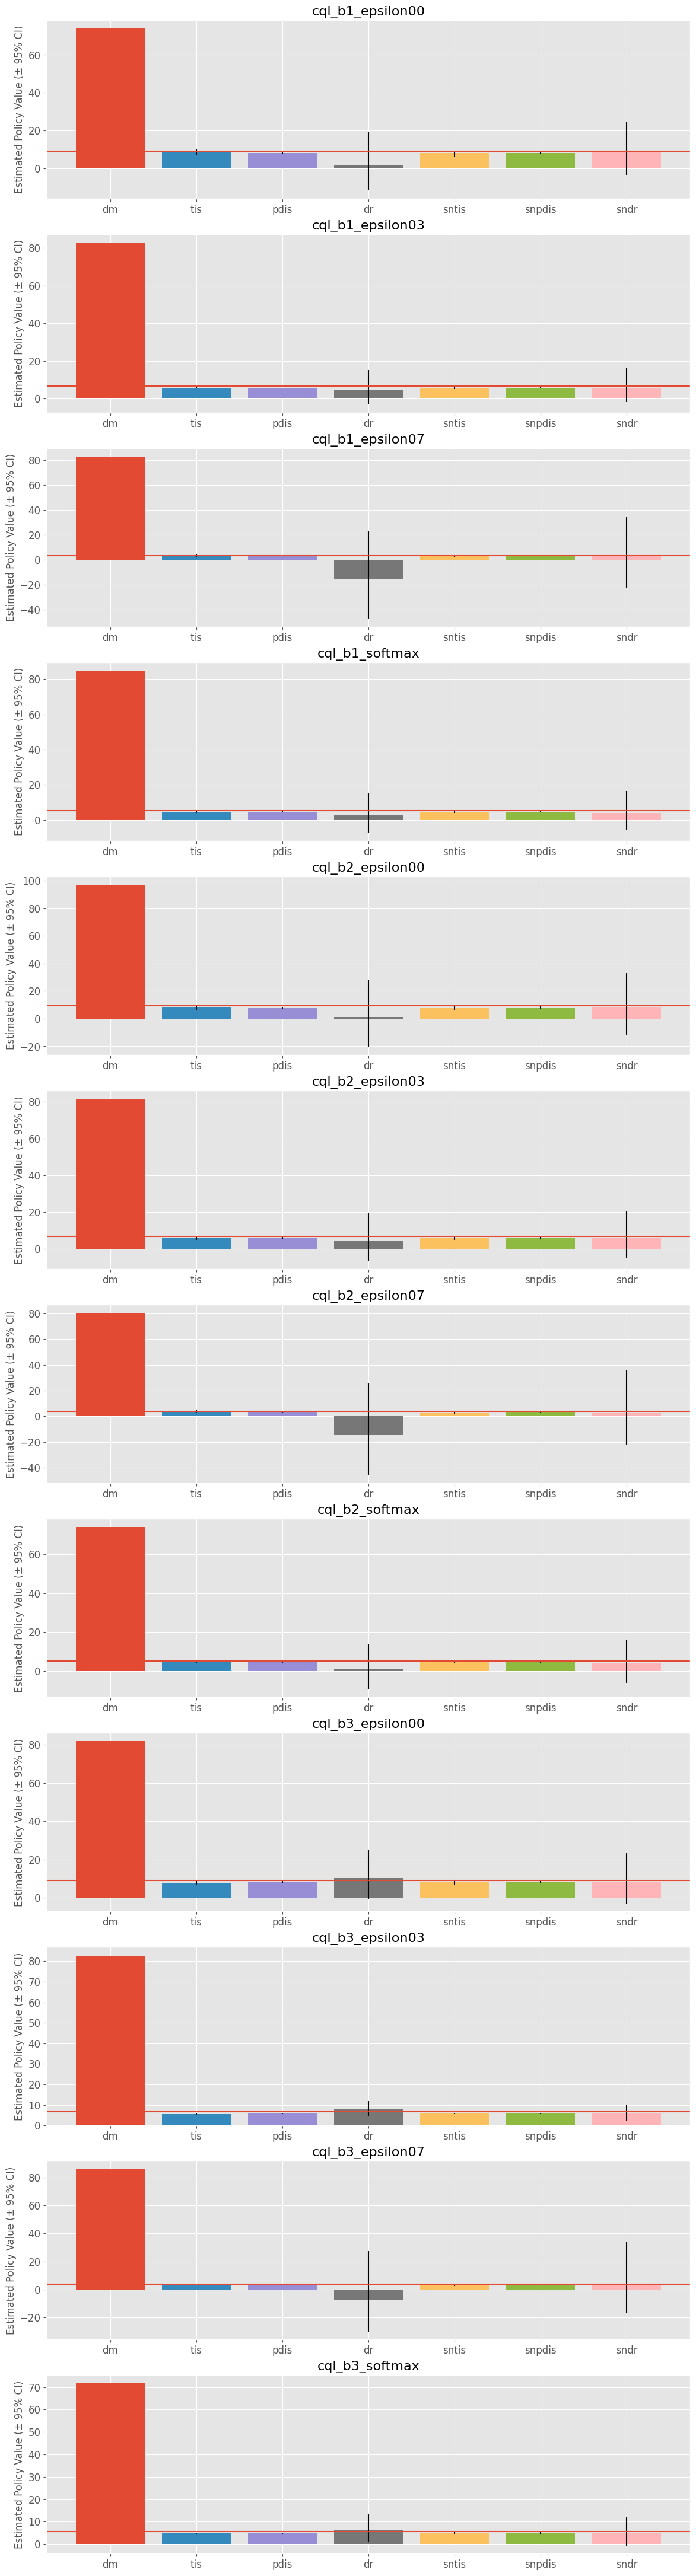

In [74]:
# visualize and compare the result
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

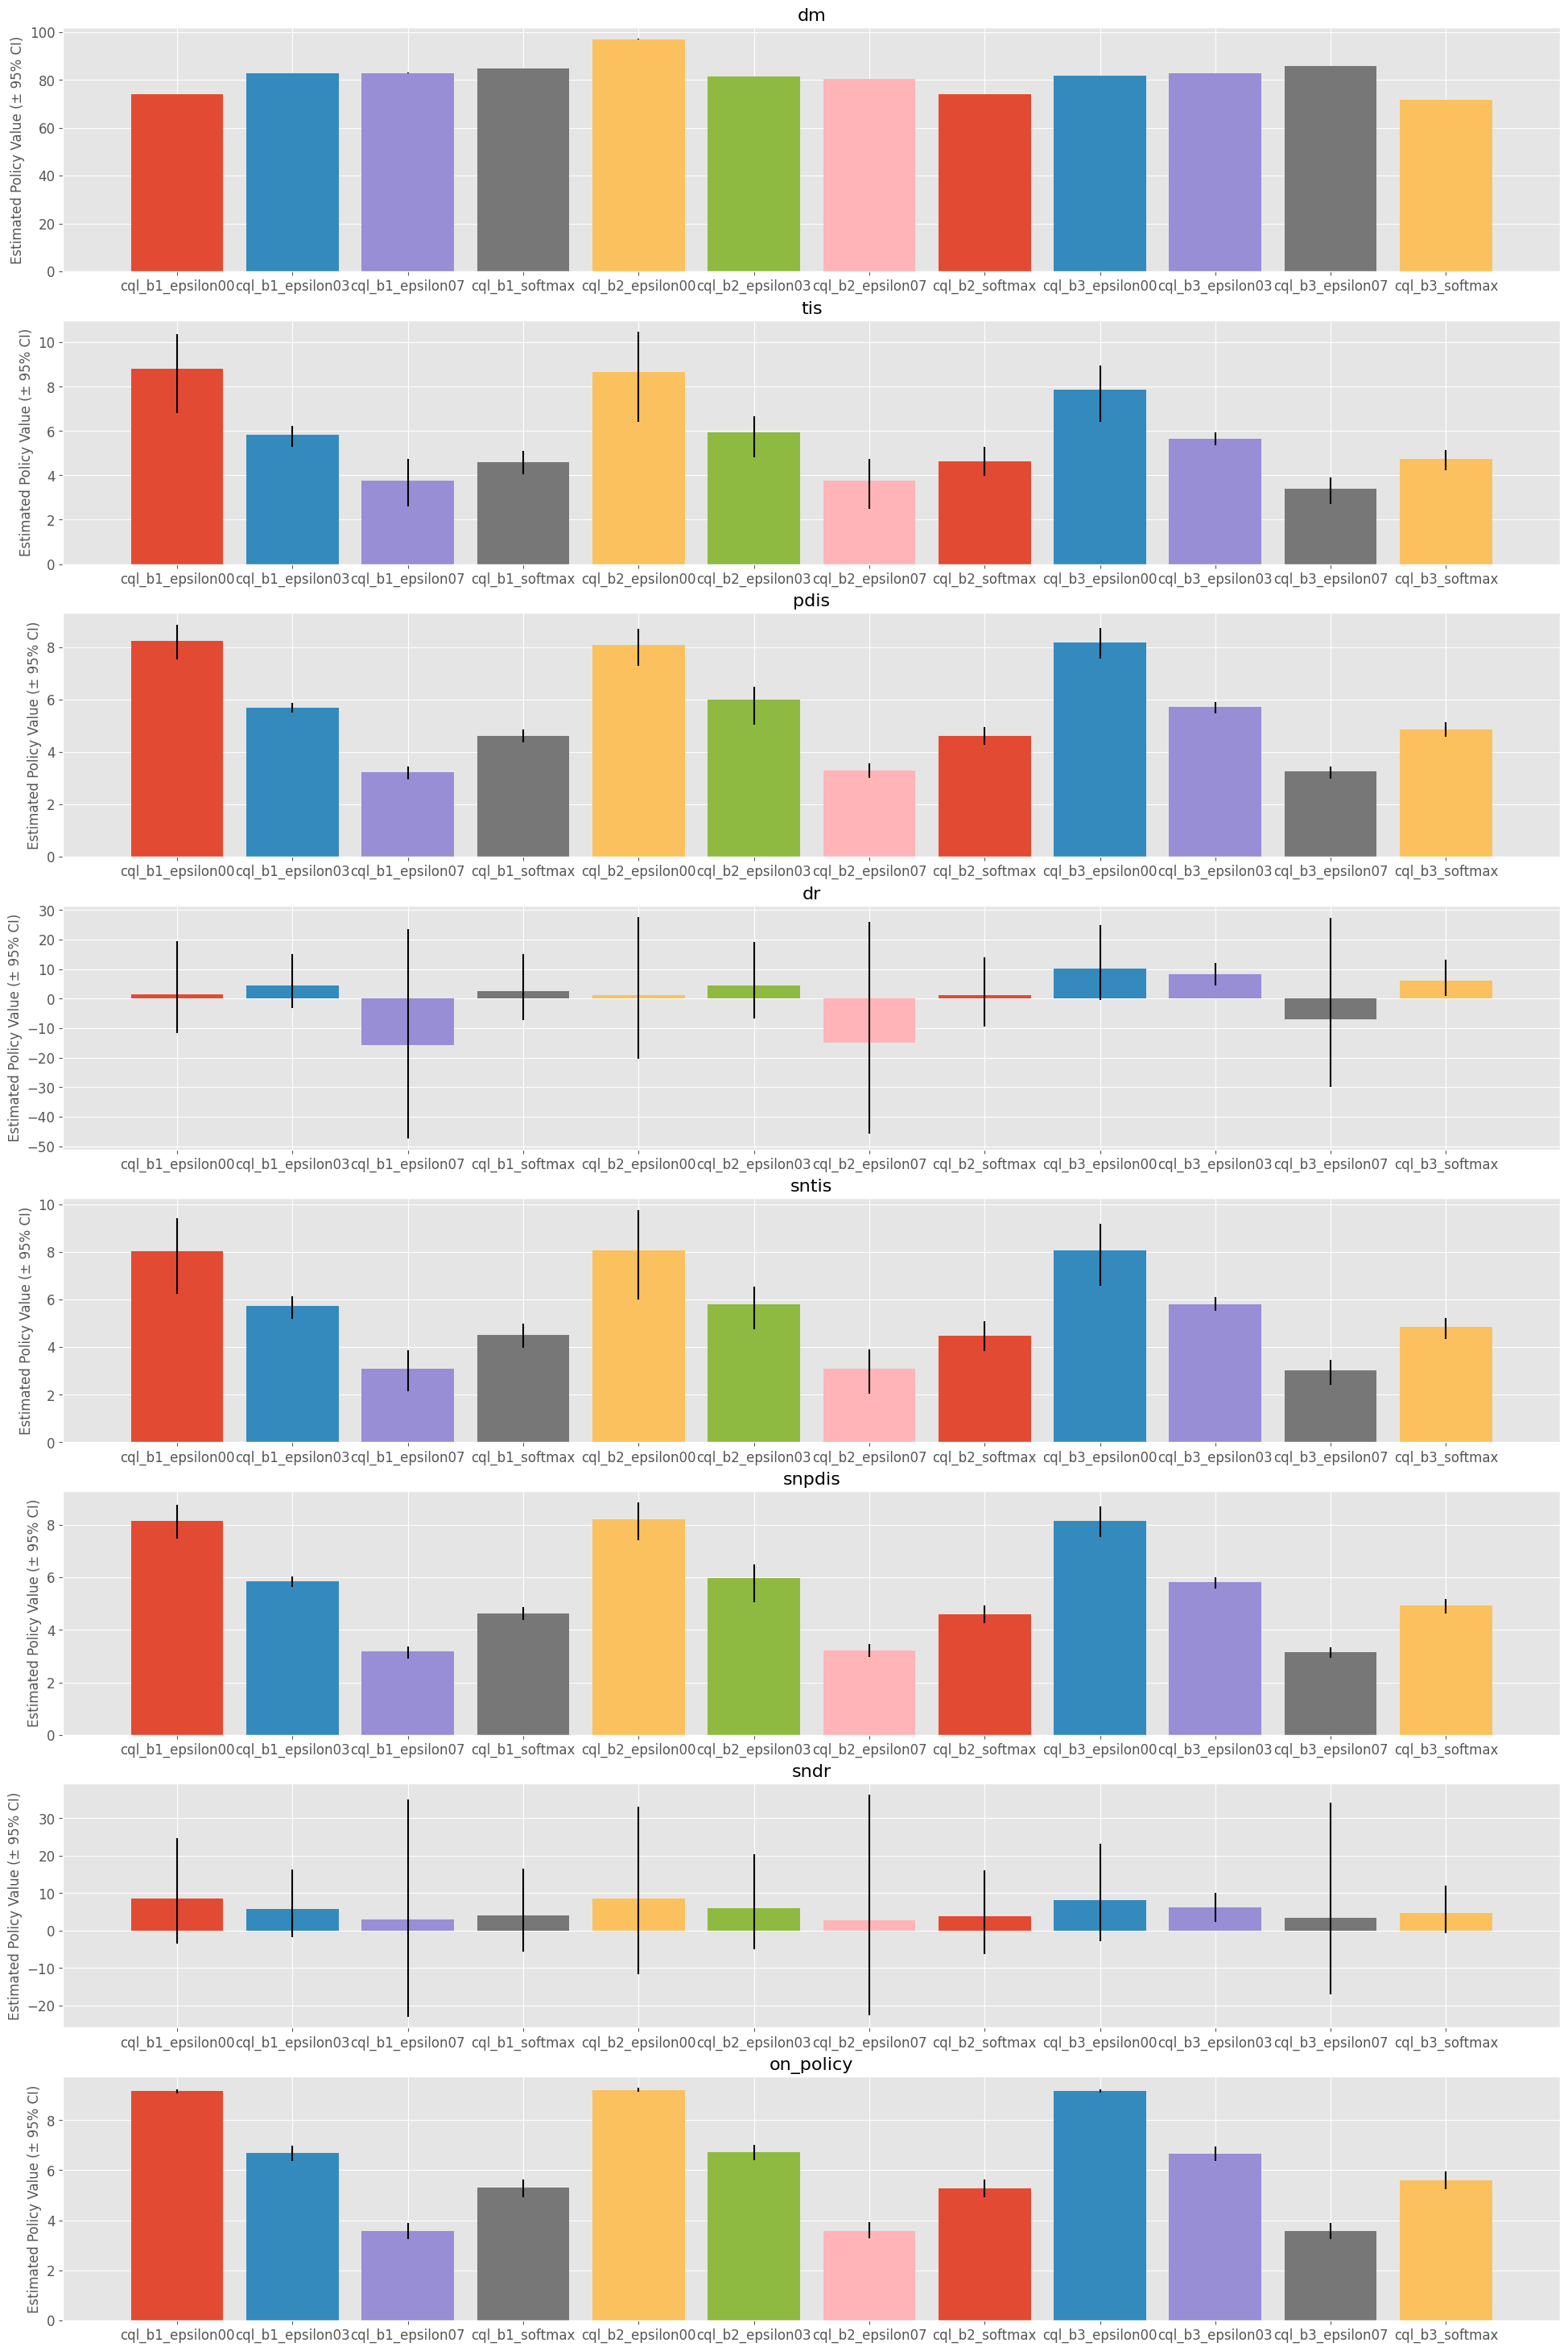

In [75]:
# we can also compare the policy value of candidate OPE estimators estimated by a single OPE estimator
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [27]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.discrete import CumulativeDistributionDM as CD_DM
from scope_rl.ope.discrete import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.discrete import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.discrete import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.discrete import CumulativeDistributionSNTDR as CD_SNDR

In [28]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

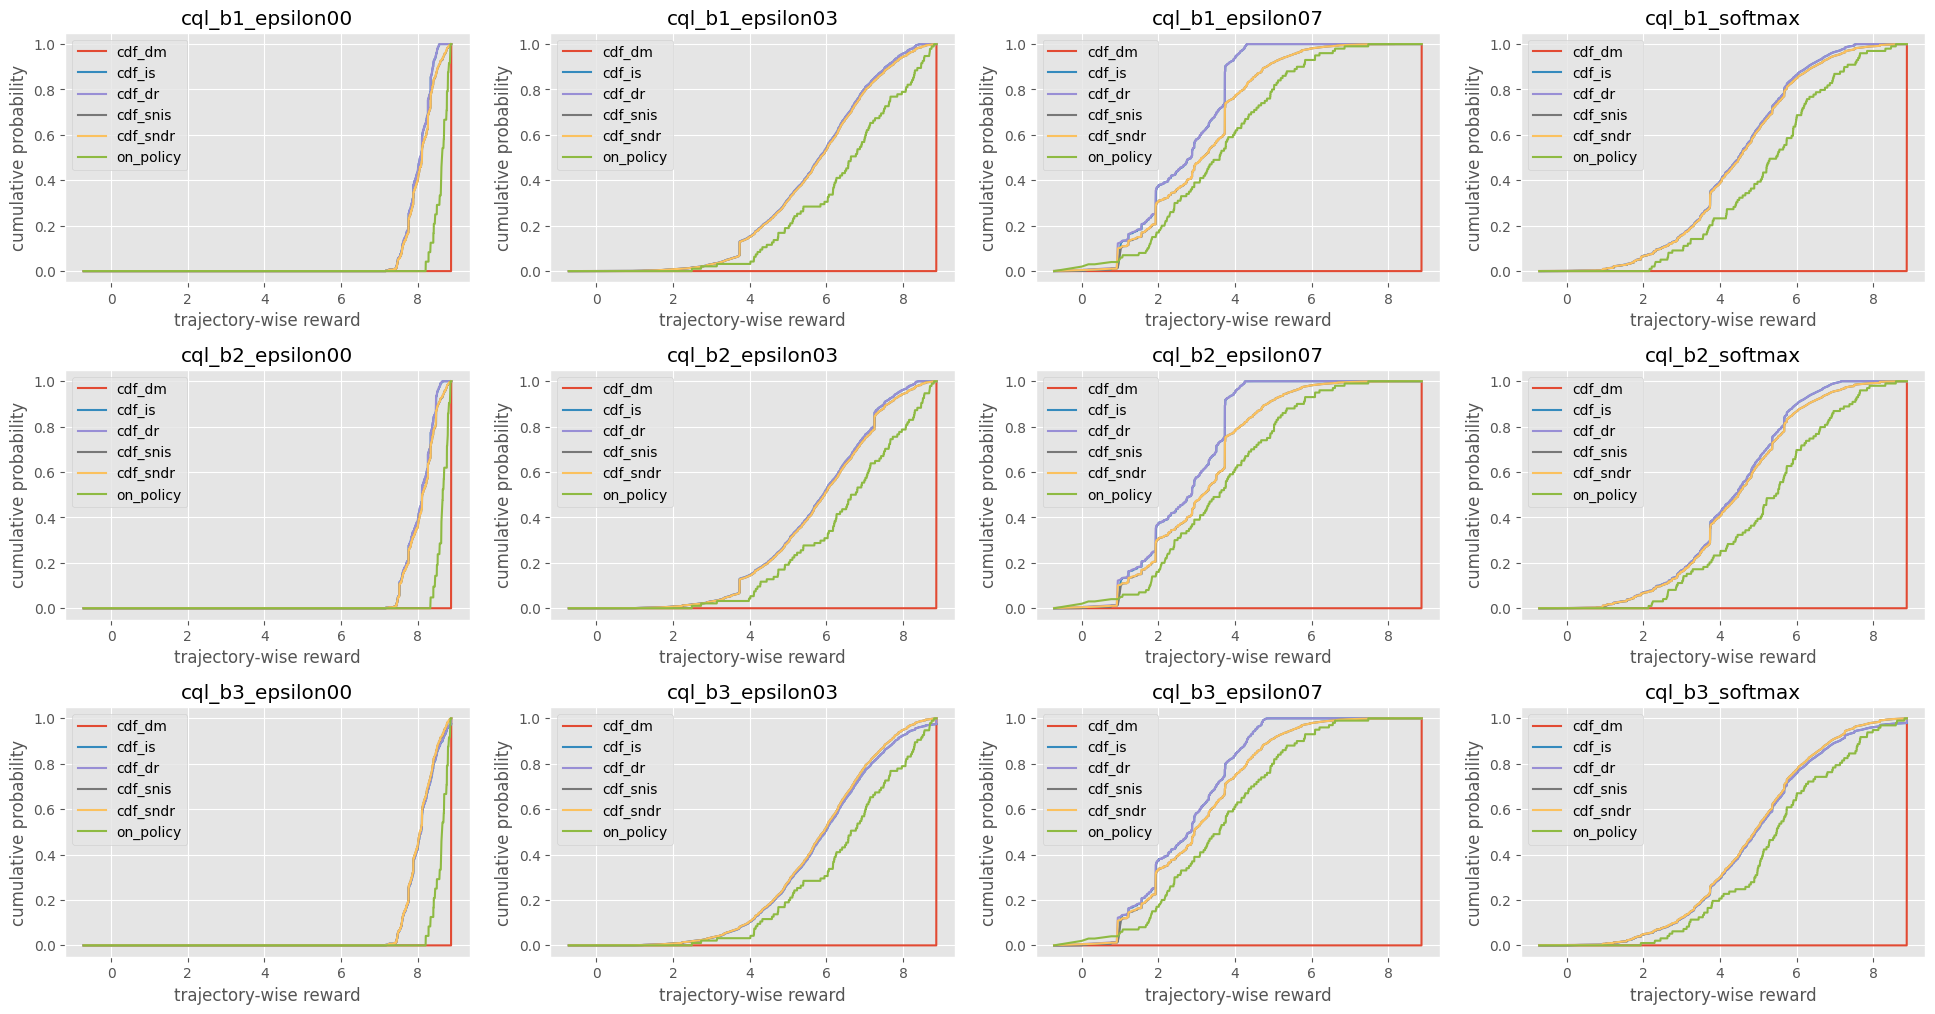

In [78]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

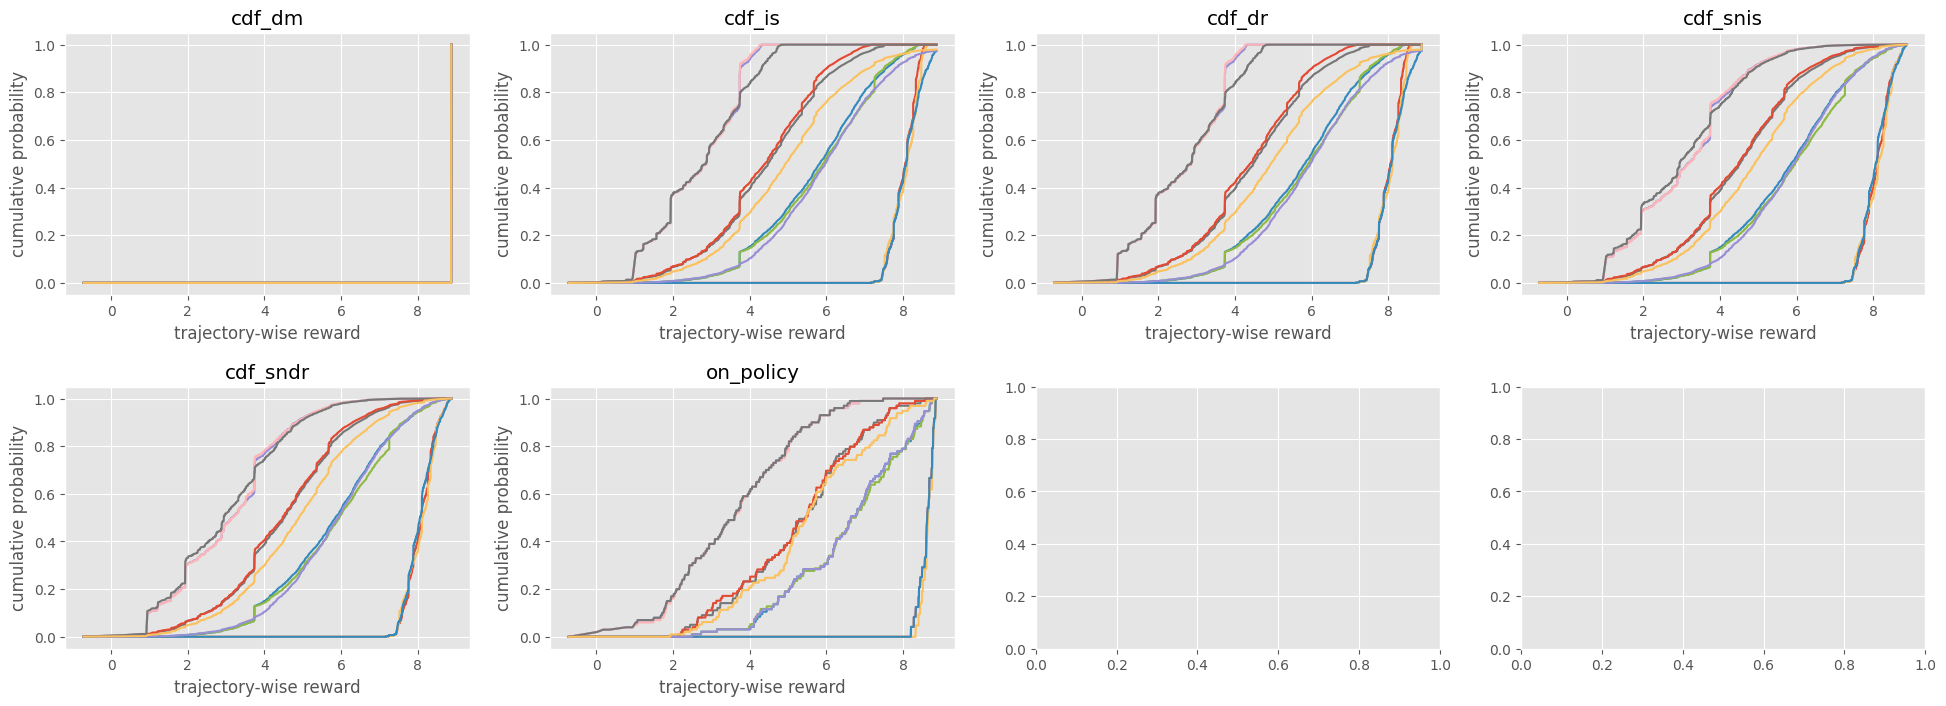

In [79]:
# cumulative distribution function comparison by each OPE estimator
# legend (evaluation policy name) is omitted here
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

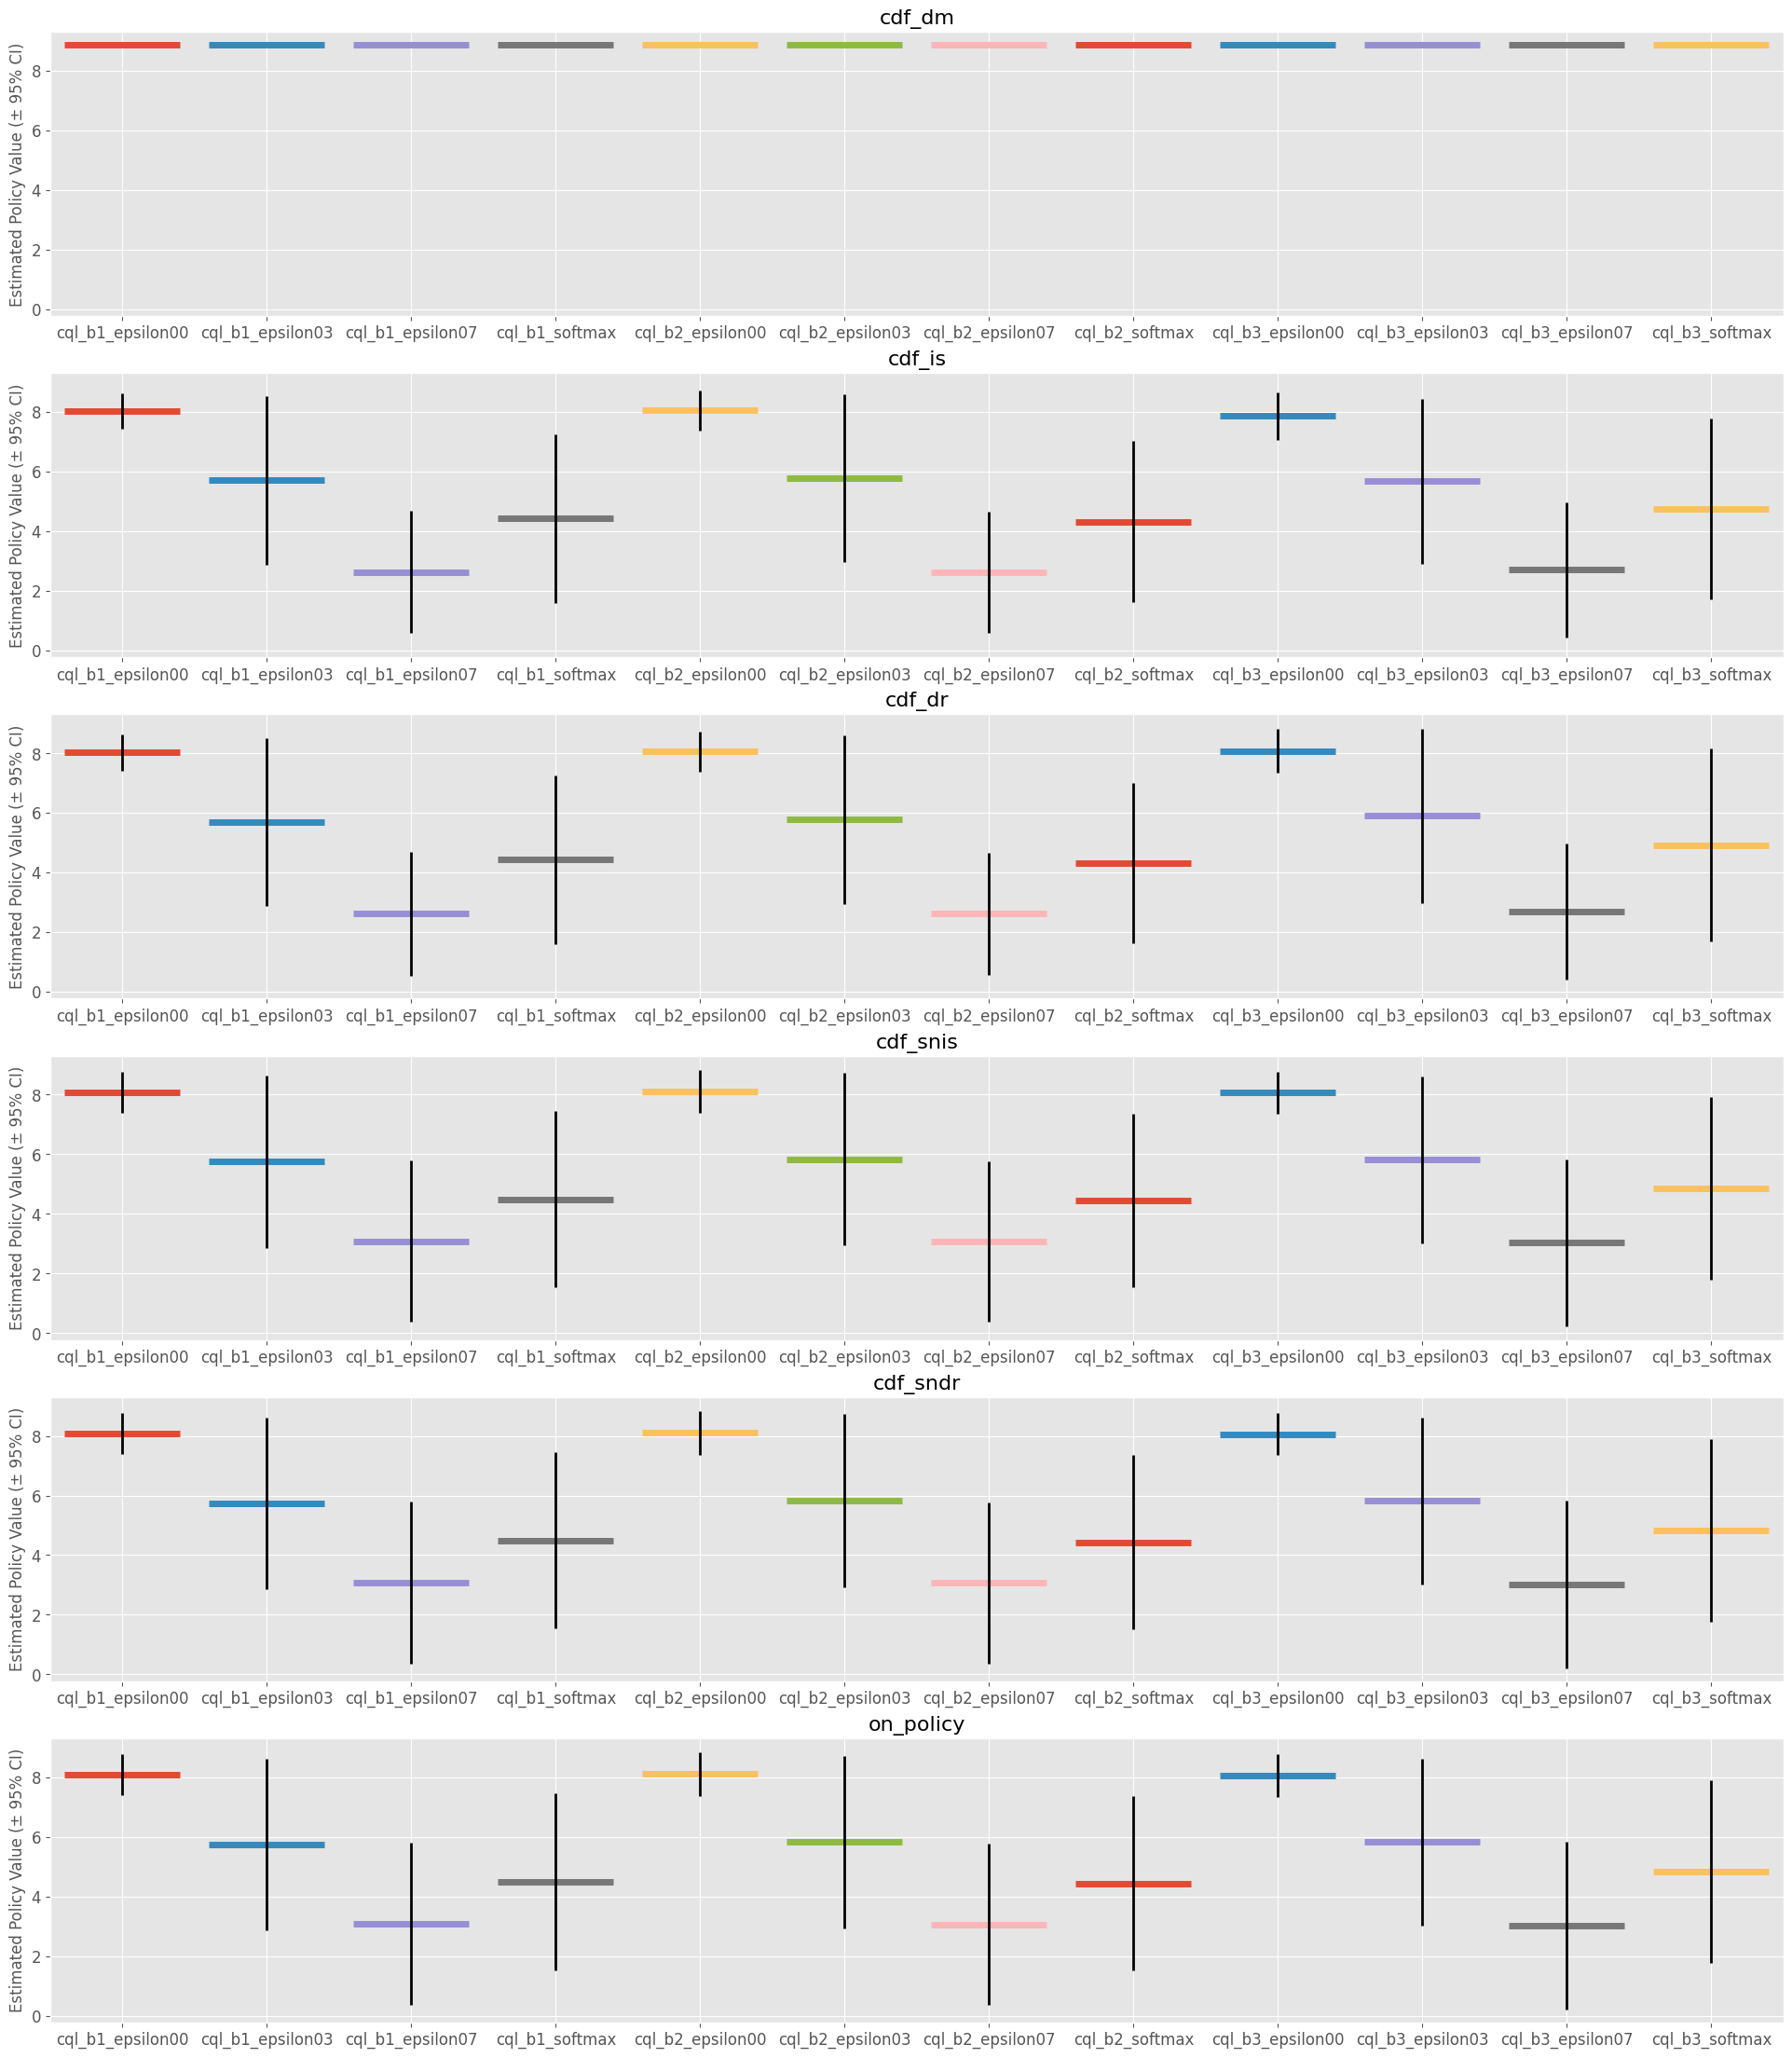

In [80]:
# policy value calculated from cumulative distribution function
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# visualize the policy value and its confidence intervals based on the mean and variance
# cd_ope.visualize_policy_value(input_dict, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

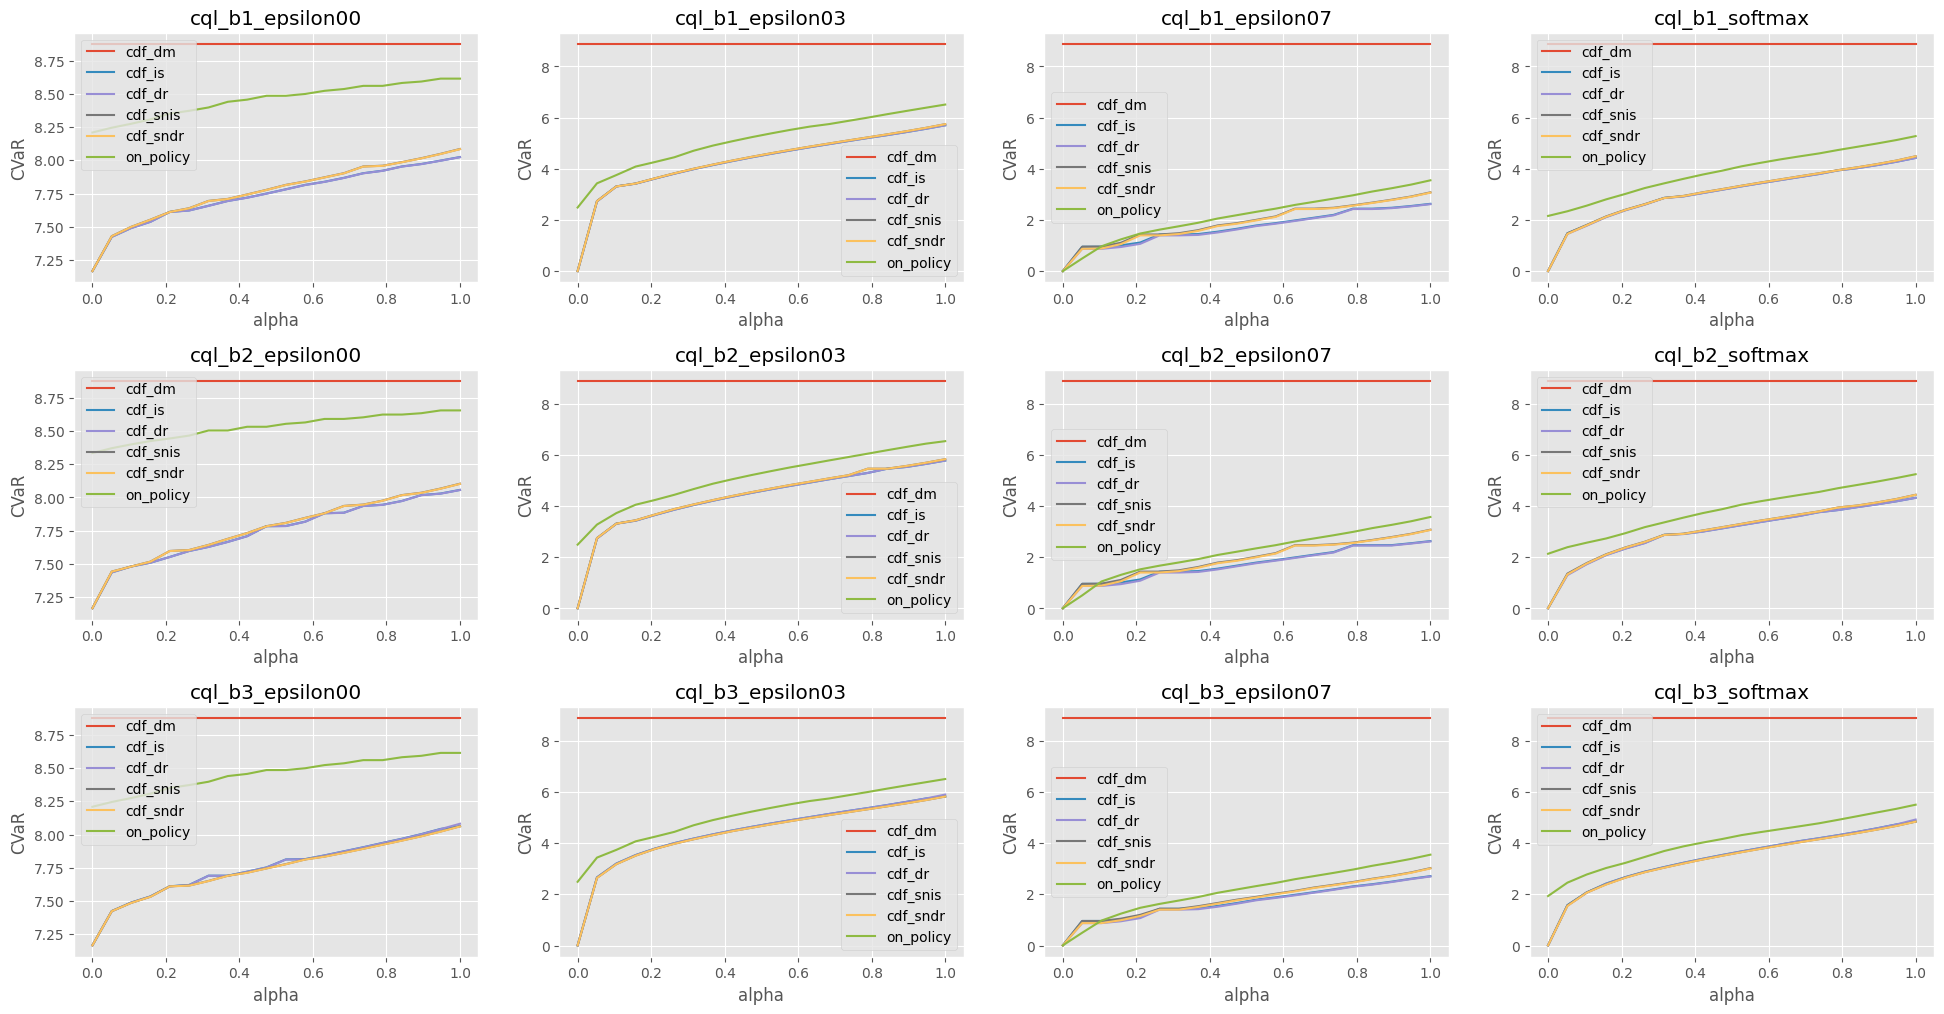

In [81]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# visualize conditional value at risk
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)
# comparison among candidate policies by an OPE estimator
# cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

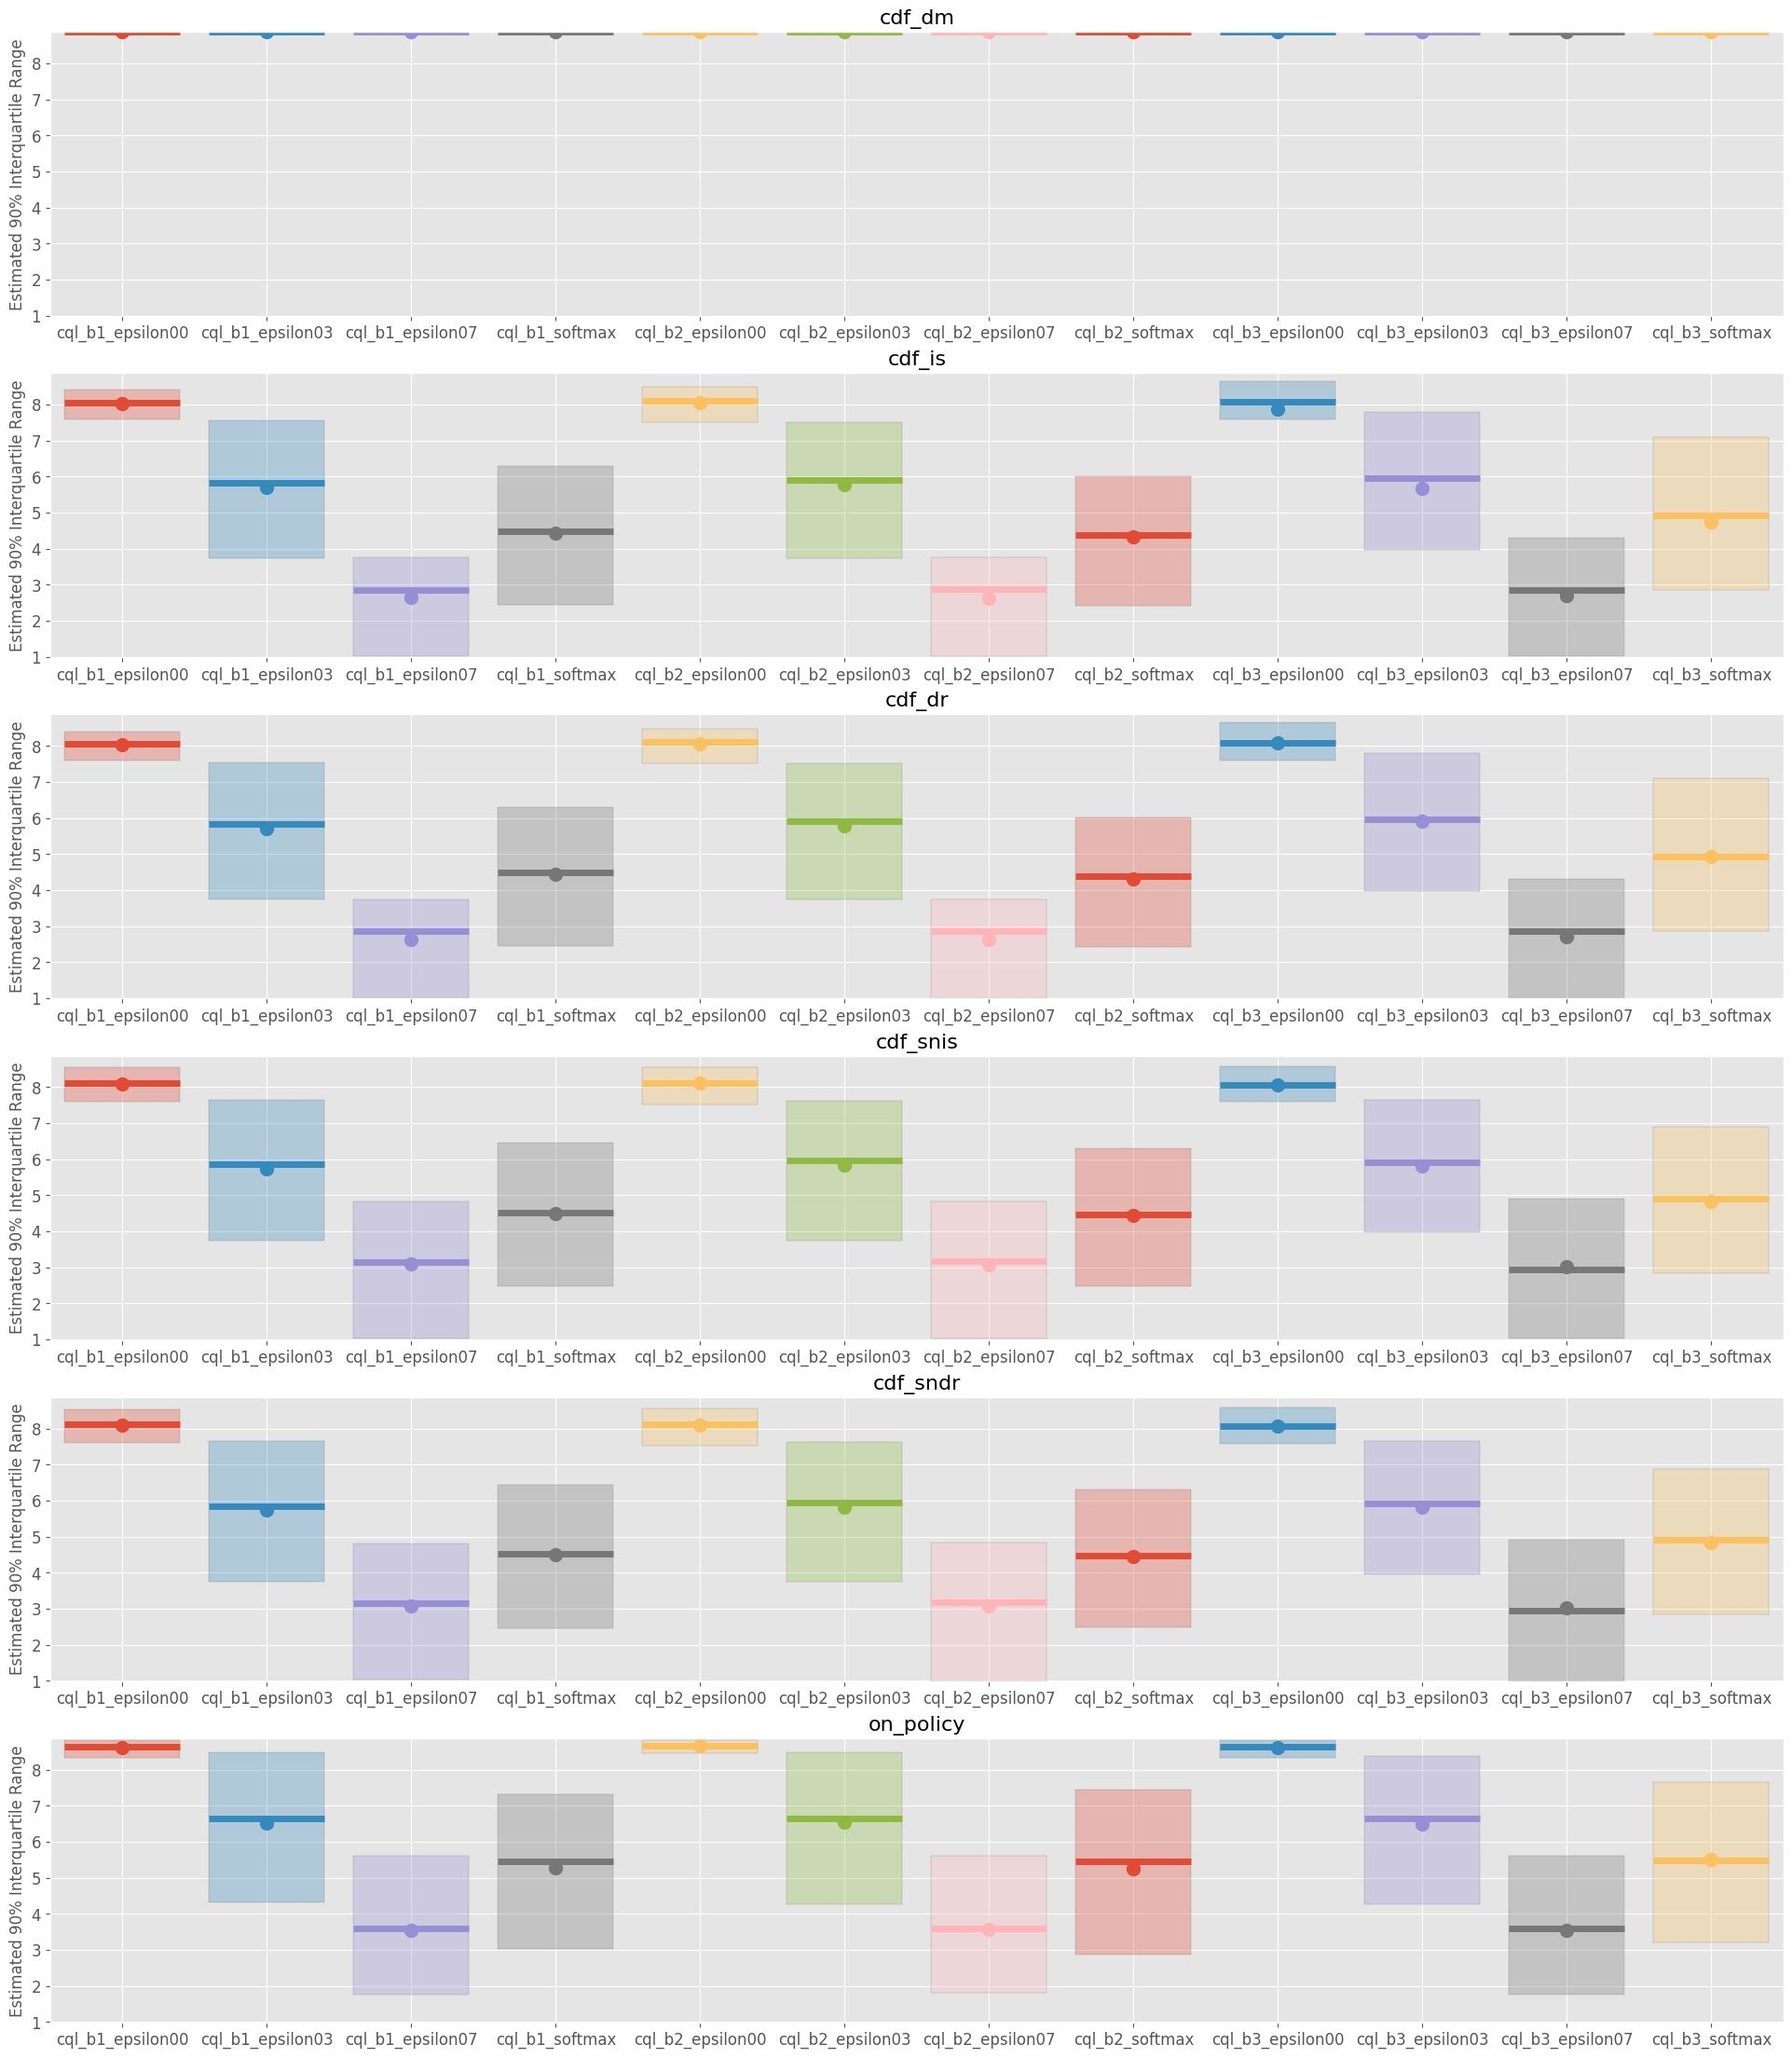

In [82]:
# interquartile range
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# visualize interquartile range
# cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [29]:
from scope_rl.ope import OffPolicySelection

In [30]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [31]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

ranking  policy_value  relative_policy_value  variance  \
0   cql_b2_epsilon00      9.214117               1.614374  0.150488   
1   cql_b3_epsilon00      9.170631               1.606755  0.168523   
2   cql_b1_epsilon00      9.161662               1.605184  0.165603   
3   cql_b2_epsilon03      6.700509               1.173973  2.689613   
4   cql_b1_epsilon03      6.657116               1.166370  2.591325   
5   cql_b3_epsilon03      6.649804               1.165089  2.593588   
6     cql_b3_softmax      5.605539               0.982127  2.864947   
7     cql_b1_softmax      5.316562               0.931497  2.584895   
8     cql_b2_softmax      5.279446               0.924994  2.637216   
9   cql_b2_epsilon07      3.560146               0.623761  2.598011   
10  cql_b1_epsilon07      3.541990               0.620580  2.636196   
11  cql_b3_epsilon07      3.537926               0.619868  2.610602   

   ranking_by_lower_quartile  lower_quartile  \
0           cql_b1_epsilon00        8.564178   
1           cql_b1_epsilon03        8.451228   
2           cql_b1_epsilon07        8.451228   
3             cql_b1_softmax        4.114895   
4           cql_b2_epsilon00        4.114895   
5           cql_b2_epsilon03        4.102752   
6           cql_b2_epsilon07        2.749838   
7             cql_b2_softmax        2.626116   
8           cql_b3_epsilon00        2.617957   
9           cql_b3_epsilon03        1.061498   
10          cql_b3_epsilon07        0.981705   
11            cql_b3_softmax        0.981705   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                      cql_b2_epsilon00                   8.441672  
1                      cql_b3_epsilon00                   8.329135  
2                      cql_b1_epsilon00                   8.329135  
3                      cql_b3_epsilon03                   3.297550  
4                      cql_b1_epsilon03                   3.297550  
5                      cql_b2_epsilon03                   3.272001  
6                        cql_b3_softmax                   2.393744  
7                        cql_b2_softmax                   2.341593  
8                        cql_b1_softmax                   2.284028  
9                      cql_b2_epsilon07                   0.203722  
10                     cql_b3_epsilon07                   0.199102  
11                     cql_b1_epsilon07                   0.199102

In [32]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [33]:
ranking_df

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0   cql_b2_epsilon00               97.063303                        17.006129   
 1   cql_b3_epsilon07               85.810152                        15.034503   
 2     cql_b1_softmax               84.772327                        14.852670   
 3   cql_b1_epsilon07               82.936706                        14.531057   
 4   cql_b1_epsilon03               82.866262                        14.518715   
 5   cql_b3_epsilon03               82.736349                        14.495953   
 6   cql_b3_epsilon00               81.848240                        14.340350   
 7   cql_b2_epsilon03               81.449633                        14.270512   
 8   cql_b2_epsilon07               80.420296                        14.090165   
 9     cql_b2_softmax               73.983527                        12.962401   
 10  cql_b1_epsilon00               73.926638                        12.952434   
 11    cql

In [34]:
metric_df

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0        dm         5729.892607         -0.069930  8.290236e-01  0.000000   
1       tis            0.512600          0.965035  3.880985e-07  0.052455   
2      pdis            0.588359          0.958042  9.543582e-07  0.052455   
3        dr           79.862459          0.517483  8.486877e-02  0.043487   
4     sntis            0.719054          0.979021  3.089801e-08  0.000000   
5    snpdis            0.560900          0.993007  1.301673e-10  0.000000   
6      sndr            0.614546          0.986014  4.116896e-09  0.000000   

   type_i_error_rate  type_ii_error_rate  
0               0.00                 0.0  
1               0.00                 0.0  
2               0.00                 0.0  
3               0.25                 0.0  
4               0.00                 0.0  
5               0.00                 0.0  
6               0.00                 0.0

In [35]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [36]:
metric_df

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0    cdf_dm           11.359335         -1.000000  0.000000e+00  5.676192   
1    cdf_is            0.989651          0.965035  3.880985e-07  0.000000   
2    cdf_dr            0.897692          0.944056  3.927261e-06  0.043487   
3  cdf_snis            0.713735          0.979021  3.089801e-08  0.000000   
4  cdf_sndr            0.718704          0.979021  3.089801e-08  0.000000   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [37]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [38]:
metric_df

ci estimator  mean_squared_error  rank_correlation        pvalue  \
0   bootstrap        dm                 NaN         -0.069930  8.290236e-01   
1   bootstrap       tis                 NaN          0.930070  1.170223e-05   
2   bootstrap      pdis                 NaN          0.923077  1.862195e-05   
3   bootstrap        dr                 NaN          0.419580  1.745190e-01   
4   bootstrap     sntis                 NaN          0.923077  1.862195e-05   
5   bootstrap    snpdis                 NaN          0.965035  3.880985e-07   
6   bootstrap      sndr                 NaN          0.482517  1.121093e-01   
7   bernstein        dm                 NaN         -0.069930  8.290236e-01   
8   bernstein       tis                 NaN          0.384615  2.170202e-01   
9   bernstein      pdis                 NaN          0.748252  5.124082e-03   
10  bernstein        dr                 NaN          0.363636  2.452650e-01   
11  bernstein     sntis                 NaN          0.384615  2.170202e-01   
12  bernstein    snpdis                 NaN          0.713287  9.201780e-03   
13  bernstein      sndr                 NaN          0.258741  4.167748e-01   
14  hoeffding        dm                 NaN          0.013986  9.655903e-01   
15  hoeffding       tis                 NaN         -0.125874  6.966831e-01   
16  hoeffding      pdis                 NaN         -0.405594  1.908359e-01   
17  hoeffding        dr                 NaN         -0.531469  7.536234e-02   
18  hoeffding     sntis                 NaN         -0.573427  5.126559e-02   
19  hoeffding    snpdis                 NaN         -0.503497  9.515737e-02   
20  hoeffding      sndr                 NaN         -0.538462  7.089432e-02   
21      ttest        dm                 NaN         -0.069930  8.290236e-01   
22      ttest       tis                 NaN          0.923077  1.862195e-05   
23      ttest      pdis                 NaN          0.937063  6.993165e-06   
24      ttest        dr                 NaN          0.426573  1.667000e-01   
25      ttest     sntis                 NaN          0.923077  1.862195e-05   
26      ttest    snpdis                 NaN          0.958042  9.543582e-07   
27      ttest      sndr                 NaN          0.258741  4.167748e-01   

    regret@1  type_i_error_rate  type_ii_error_rate  
0   0.000000           0.000000                 0.0  
1   0.052455           0.000000                 0.0  
2   0.052455           0.000000                 0.0  
3   2.564314           0.916667                 0.0  
4   0.043487           0.000000                 0.0  
5   0.043487           0.000000                 0.0  
6   2.564314           0.916667                 0.0  
7   0.000000           0.000000                 0.0  
8   2.564314           0.166667                 0.0  
9   0.052455           0.000000                 0.0  
10  2.564314           0.916667                 0.0  
11  2.564314           0.166667                 0.0  
12  0.043487           0.000000                 0.0  
13  2.564314           0.916667                 0.0  
14  3.608578           1.000000                 0.0  
15  2.564314           1.000000                 0.0  
16  2.564314           1.000000                 0.0  
17  3.608578           1.000000                 0.0  
18  2.564314           1.000000                 0.0  
19  2.564314           1.000000                 0.0  
20  3.608578           1.000000                 0.0  
21  0.000000           0.000000                 0.0  
22  0.052455           0.000000                 0.0  
23  0.052455           0.000000                 0.0  
24  2.564314           0.833333                 0.0  
25  0.043487           0.000000                 0.0  
26  0.043487           0.000000                 0.0  
27  2.564314           0.916667                 0.0

In [39]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [40]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           30.823278         -1.000000  0.000000     NaN   
1    cdf_is           11.042050          0.167832  0.602099     NaN   
2    cdf_dr           11.106931          0.167832  0.602099     NaN   
3  cdf_snis           10.998222          0.223776  0.484452     NaN   
4  cdf_sndr           11.065957          0.223776  0.484452     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [41]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [42]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           37.350934         -1.000000  0.000000     NaN   
1    cdf_is            0.676691          0.951049  0.000002     NaN   
2    cdf_dr            0.662383          0.951049  0.000002     NaN   
3  cdf_snis            0.672011          0.951049  0.000002     NaN   
4  cdf_sndr            0.657487          0.951049  0.000002     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [43]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [44]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  9.214117  9.214117  9.214117  9.214117       NaN   
1         dm     1  3.537926  9.214117  3.537926  6.376022  4.013674   
2         dm     2  5.316562  9.214117  3.537926  6.022868  2.903264   
3         dm     3  3.541990  9.214117  3.537926  5.402649  2.675441   
4         dm     4  6.657116  9.214117  3.537926  5.653542  2.383951   
5         dm     5  6.649804  9.214117  3.537926  5.819586  2.170715   
6         dm     6  9.170631  9.214117  3.537926  6.298306  2.351783   
7         dm     7  6.700509  9.214117  3.537926  6.348582  2.181967   
8         dm     8  3.560146  9.214117  3.537926  6.038756  2.242718   
9         dm     9  5.279446  9.214117  3.537926  5.962825  2.128045   
10        dm    10  9.161662  9.214117  3.537926  6.253628  2.237398   
11        dm    11  5.605539  9.214117  3.537926  6.199621  2.141464   
0        tis     0  9.161662  9.161662  9.161662  9.161662       NaN   
1        tis     1  9.214117  9.214117  9.161662  9.187890  0.037091   
2        tis     2  9.170631  9.214117  9.161662  9.182137  0.028057   
3        tis     3  6.700509  9.214117  6.700509  8.561730  1.241025   
4        tis     4  6.657116  9.214117  6.657116  8.180807  1.371356   
5        tis     5  6.649804  9.214117  6.649804  7.925640  1.376647   
6        tis     6  5.605539  9.214117  5.605539  7.594197  1.532409   
7        tis     7  5.279446  9.214117  5.279446  7.304853  1.637855   
8        tis     8  5.316562  9.214117  5.279446  7.083932  1.669282   
9        tis     9  3.541990  9.214117  3.541990  6.729738  1.931690   
10       tis    10  3.560146  9.214117  3.541990  6.441593  2.066781   
11       tis    11  3.537926  9.214117  3.537926  6.199621  2.141464   
0       pdis     0  9.161662  9.161662  9.161662  9.161662       NaN   
1       pdis     1  9.170631  9.170631  9.161662  9.166146  0.006342   
2       pdis     2  9.214117  9.214117  9.161662  9.182137  0.028057   
3       pdis     3  6.700509  9.214117  6.700509  8.561730  1.241025   
4       pdis     4  6.649804  9.214117  6.649804  8.179345  1.373390   
5       pdis     5  6.657116  9.214117  6.649804  7.925640  1.376647   

    safety_violation_rate  sharpe_ratio  
0                0.000000           NaN  
1                0.500000      0.873656  
2                0.666667      1.207803  
3                0.750000      1.310651  
4                0.600000      1.470906  
5                0.500000      1.615398  
6                0.428571      1.491026  
7                0.375000      1.607068  
8                0.444444      1.563535  
9                0.500000      1.647789  
10               0.454545      1.567253  
11               0.500000      1.637464  
0                0.000000           NaN  
1                0.000000     94.538377  
2                0.000000    124.981189  
3                0.000000      2.825542  
4                0.000000      2.557008  
5                0.000000      2.547181  
6                0.142857      2.288272  
7                0.250000      2.140952  
8                0.333333      2.100645  
9                0.400000      1.815286  
10               0.454545      1.696633  
11               0.500000      1.637464  
0                0.000000           NaN  
1                0.000000    546.085858  
2                0.000000    124.981189  
3                0.000000      2.825542  
4                0.000000      2.553222  
5                0.000000      2.547181

In [45]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [46]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0  5.605539  5.605539  5.605539  5.605539       NaN   
1    cdf_dm     1  3.537926  5.605539  3.537926  4.571733  1.462024   
2    cdf_dm     2  6.649804  6.649804  3.537926  5.264423  1.583735   
3    cdf_dm     3  9.170631  9.170631  3.537926  6.240975  2.342383   
4    cdf_dm     4  5.279446  9.170631  3.537926  6.048669  2.073638   

   safety_violation_rate  sharpe_ratio  
0               1.000000           NaN  
1               1.000000      0.000000  
2               0.666667      0.594958  
3               0.500000      1.478444  
4               0.600000      1.670051

In [47]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [48]:
topk_metric_df.head()

ci estimator  topk      k-th      best     worst      mean  \
0  bootstrap        dm     0  6.657116  6.657116  6.657116  6.657116   
1  bootstrap        dm     1  3.541990  6.657116  3.541990  5.099553   
2  bootstrap        dm     2  6.700509  6.700509  3.541990  5.633205   
3  bootstrap        dm     3  9.161662  9.161662  3.541990  6.515319   
4  bootstrap        dm     4  9.170631  9.170631  3.541990  7.046381   

        std  safety_violation_rate  sharpe_ratio  
0       NaN               0.000000           NaN  
1  2.202727               0.500000      0.431087  
2  1.811175               0.333333      0.548241  
3  2.302044               0.250000      1.500455  
4  2.320494               0.200000      1.492390

In [49]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [50]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0  8.527876  8.527876  8.527876  8.527876       NaN   
1        dm     1  0.792303  8.527876  0.792303  4.660089  5.469876   
2        dm     2  2.514058  8.527876  0.792303  3.944745  4.061394   
3        dm     3  0.792303  8.527876  0.792303  3.156635  3.671660   
4        dm     4  3.756718  8.527876  0.792303  3.276651  3.191056   

   safety_violation_rate  sharpe_ratio  
0               0.000000           NaN  
1               0.500000      1.007383  
2               0.666667      1.356741  
3               0.750000      1.500755  
4               0.800000      1.726783

In [51]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [52]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0  2.728654  2.728654  2.728654  2.728654       NaN   
1    cdf_dm     1  0.792303  2.728654  0.792303  1.760479  1.369207   
2    cdf_dm     2  3.735605  3.735605  0.792303  2.418854  1.495907   
3    cdf_dm     3  8.437541  8.437541  0.792303  3.923526  3.247764   
4    cdf_dm     4  2.533838  8.437541  0.792303  3.645588  2.880491   

   safety_violation_rate  sharpe_ratio  
0                   1.00           NaN  
1                   1.00      0.000000  
2                   1.00      0.479969  
3                   0.75      1.668817  
4                   0.80      1.881598

In [53]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [54]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0  4.324946  4.324946  4.324946  4.324946       NaN   
1        dm     1  1.747760  4.324946  1.747760  3.036353  1.822346   
2        dm     2  4.432435  4.432435  1.747760  3.501714  1.519919   
3        dm     3  8.617136  8.617136  1.747760  4.780569  2.842884   
4        dm     4  8.617136  8.617136  1.747760  5.547882  3.000890   

   safety_violation_rate  sharpe_ratio  
0                   1.00           NaN  
1                   1.00      0.279729  
2                   1.00      0.406108  
3                   0.75      1.689113  
4                   0.60      1.600176

In [55]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [56]:
topk_metric_df.head()

estimator  topk      k-th      best    worst      mean       std  \
0    cdf_dm     0  1.747760  1.747760  1.74776  1.747760       NaN   
1    cdf_dm     1  1.747760  1.747760  1.74776  1.747760  0.000000   
2    cdf_dm     2  1.796910  1.796910  1.74776  1.764143  0.028377   
3    cdf_dm     3  2.891789  2.891789  1.74776  2.046055  0.564299   
4    cdf_dm     4  3.042798  3.042798  1.74776  2.245403  0.661456   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0           NaN  
2                    1.0           0.0  
3                    1.0           0.0  
4                    1.0           0.0

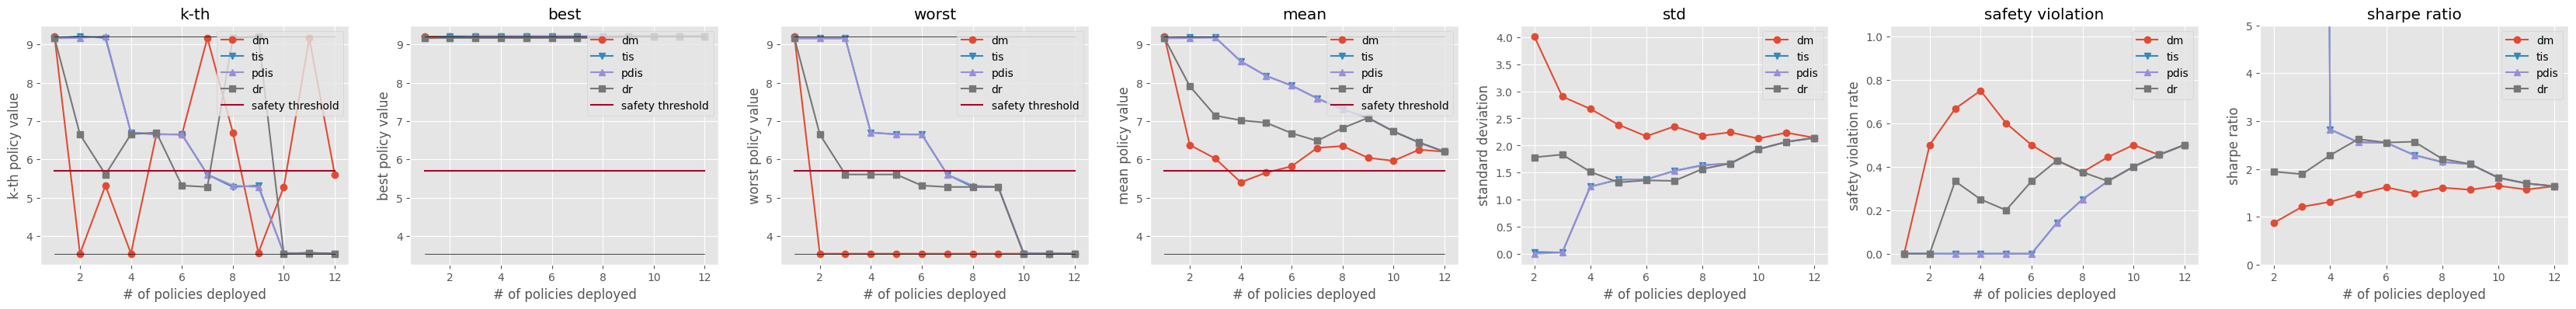

In [57]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

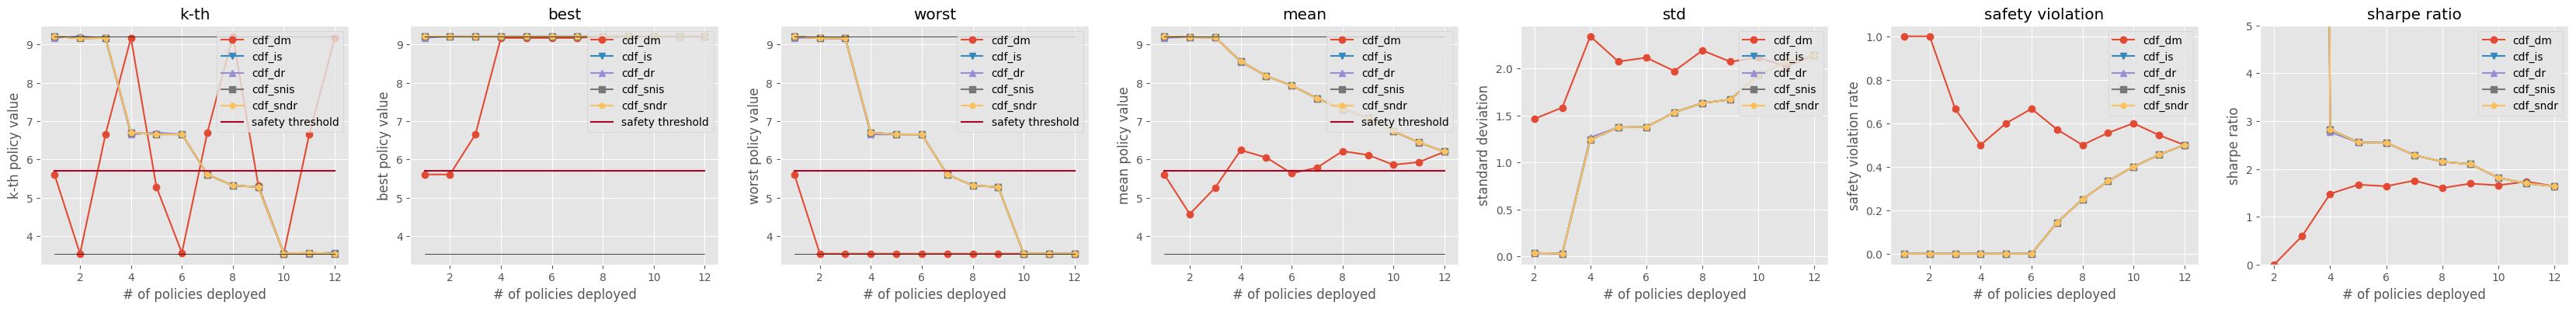

In [58]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

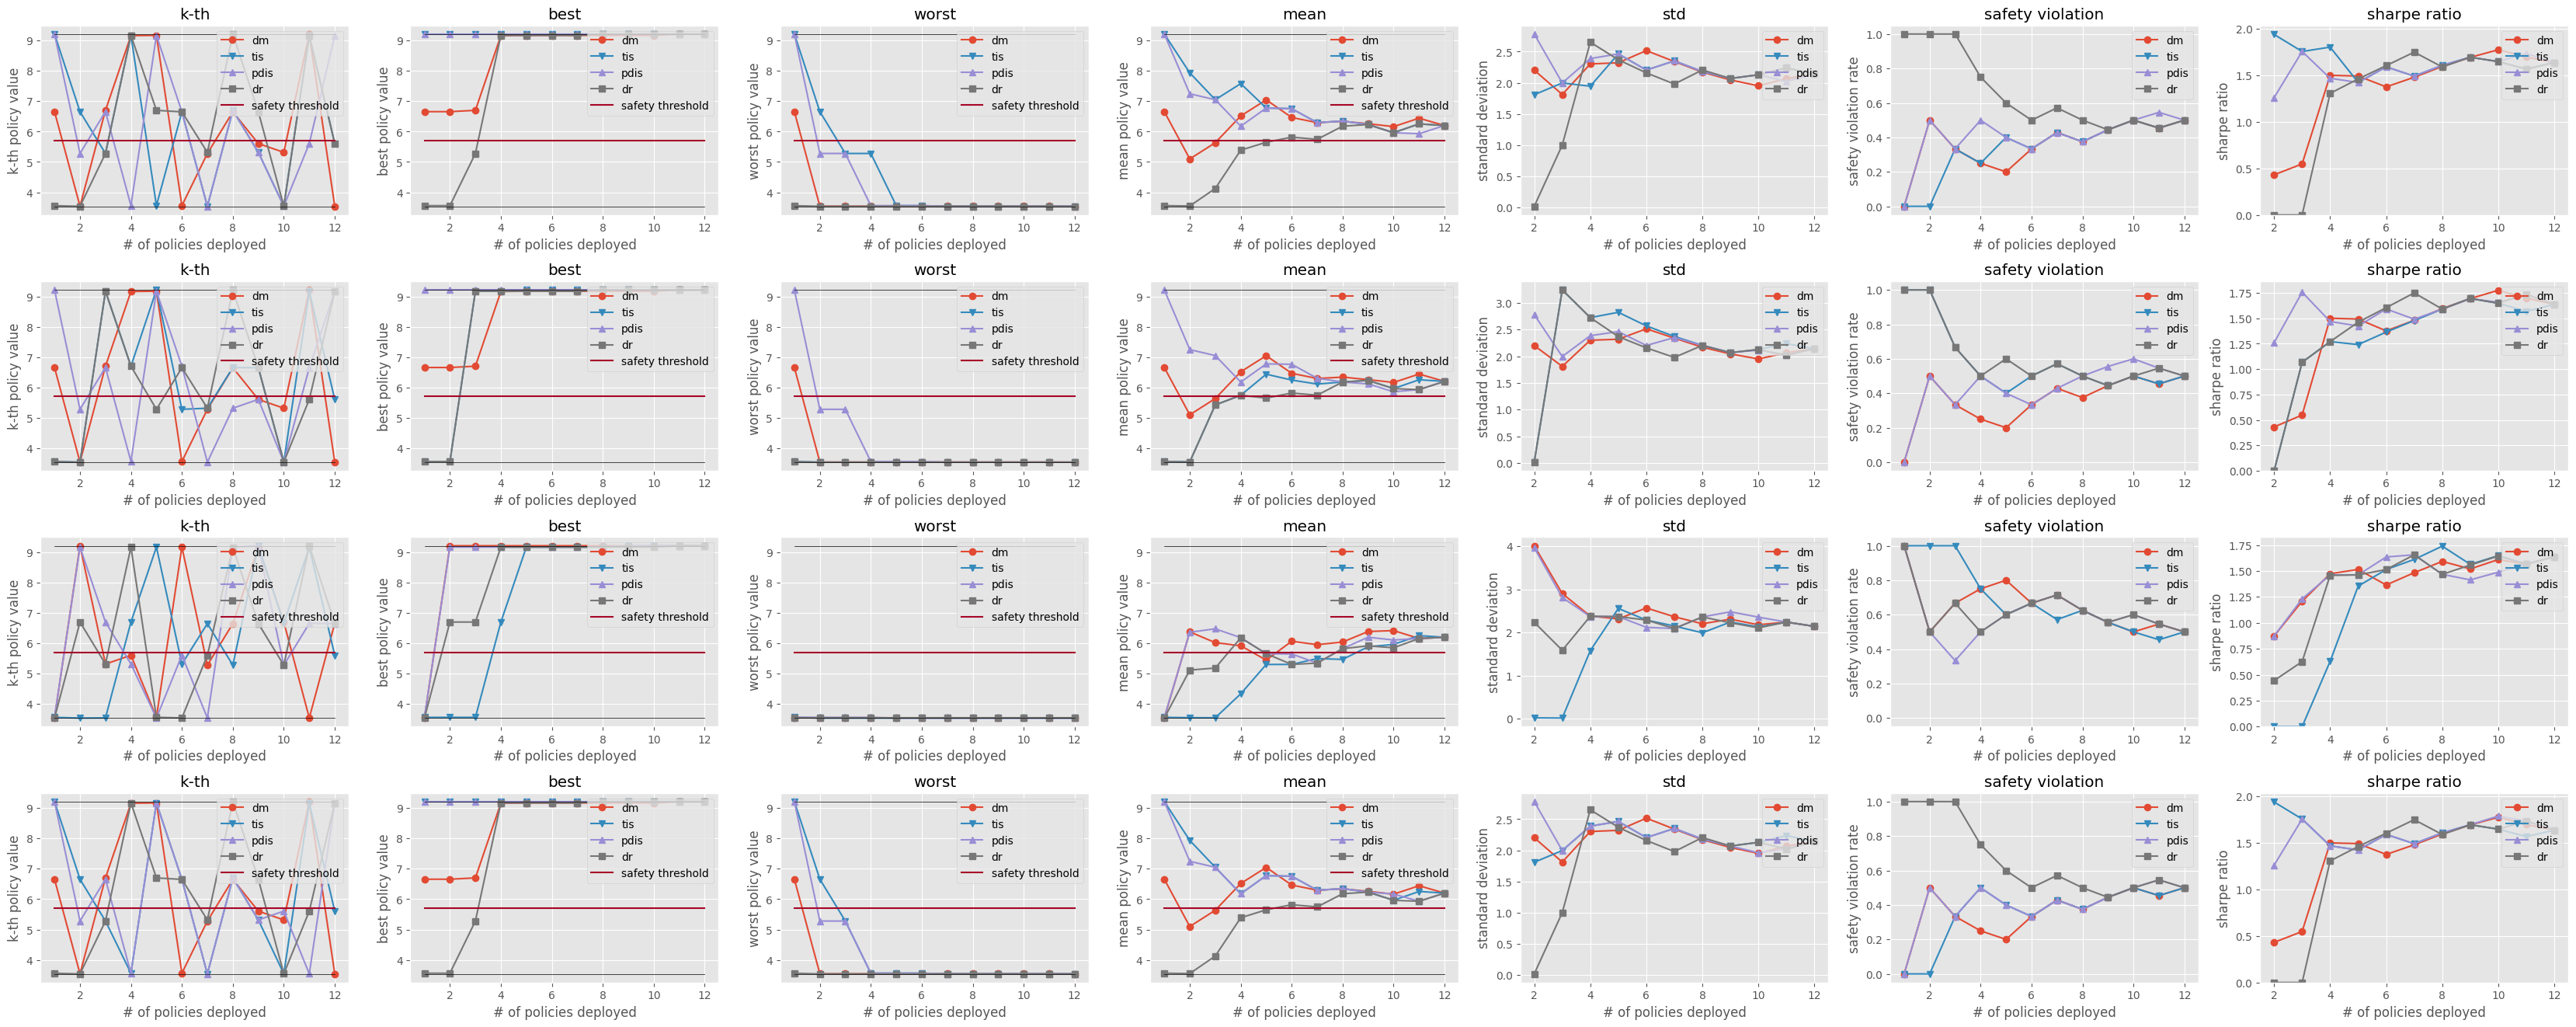

In [59]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    relative_safety_criteria=1.0,
    legend=True,
    random_state=12345,
)

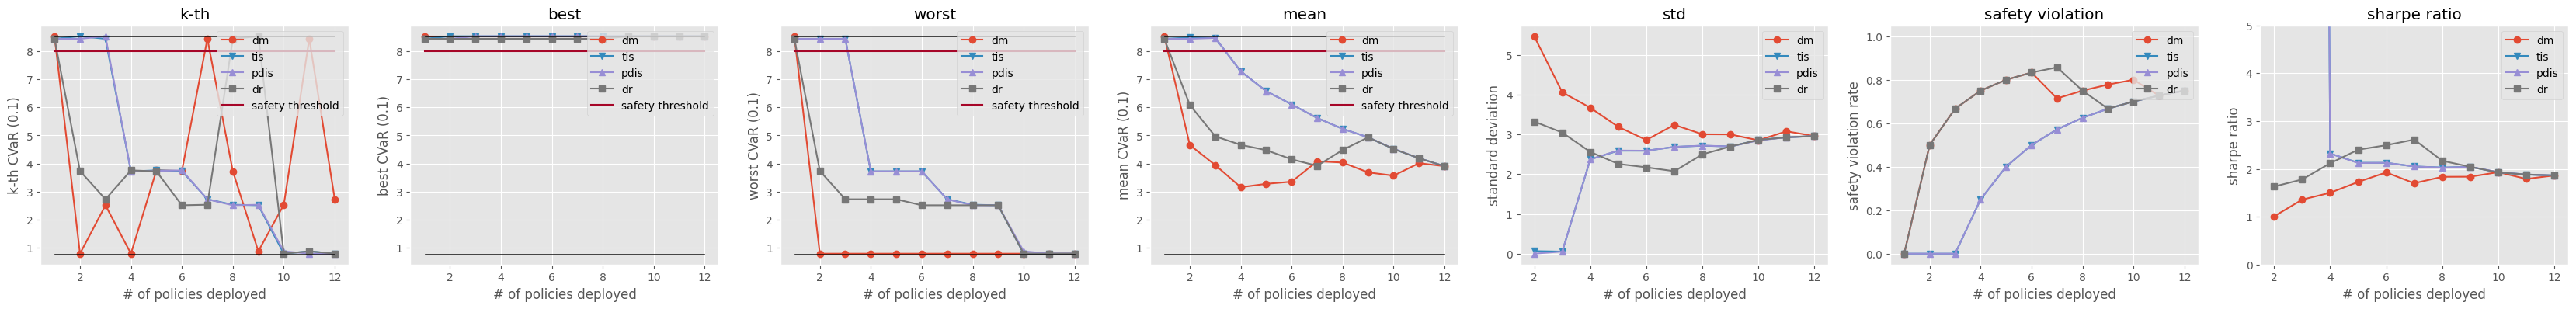

In [60]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=8.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

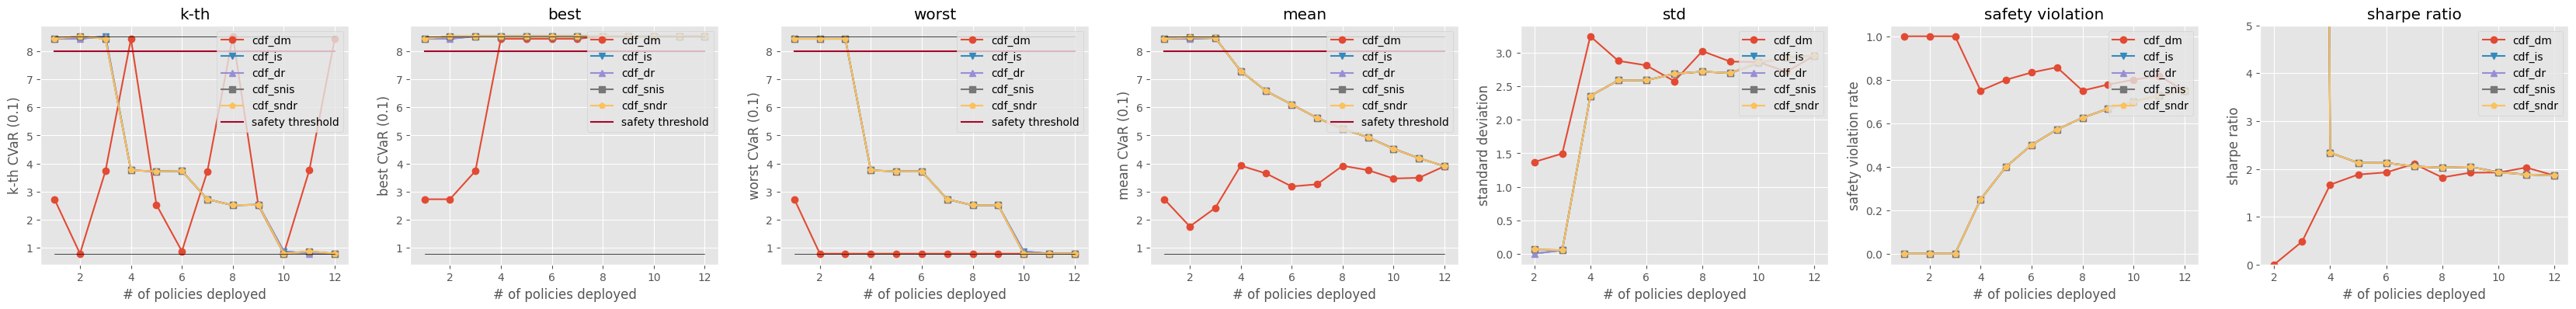

In [61]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=8.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

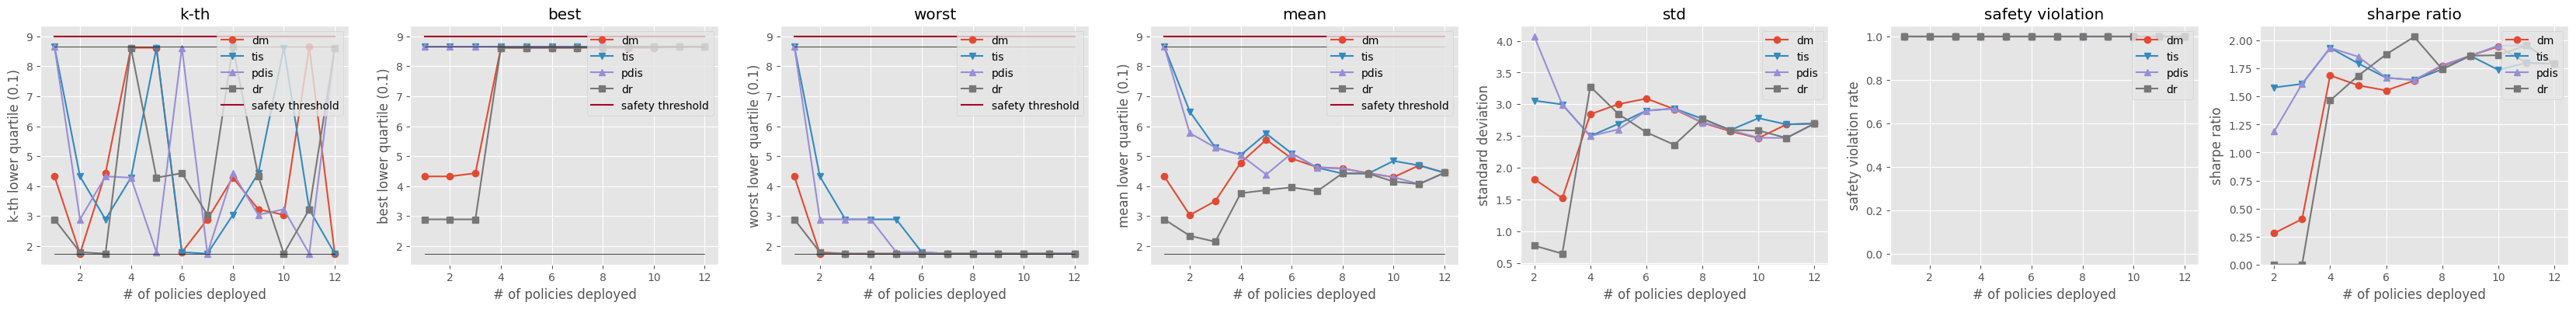

In [62]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
)

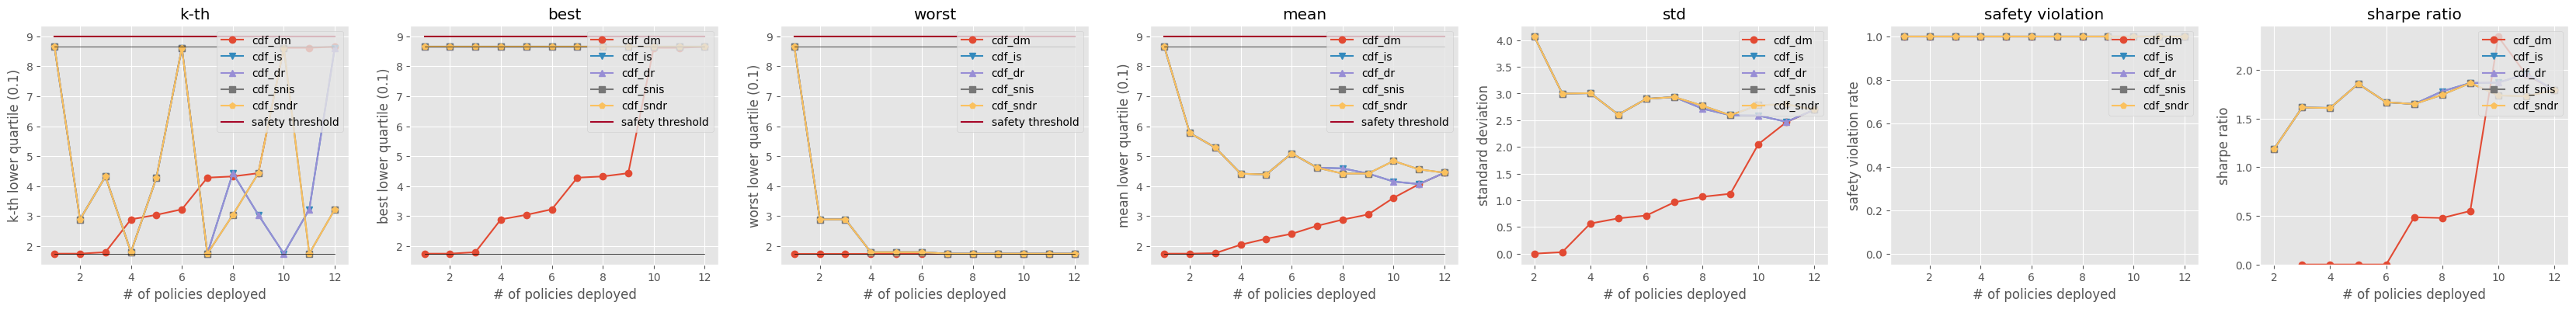

In [63]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
)

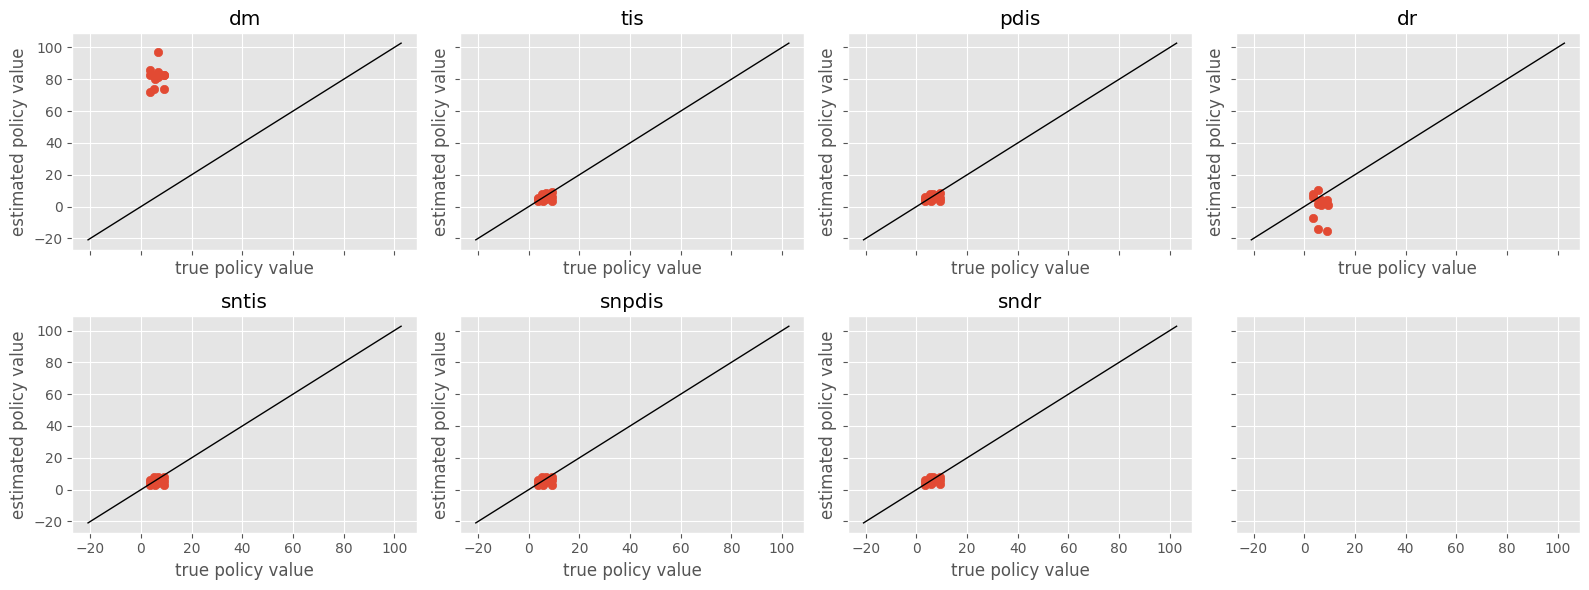

In [64]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

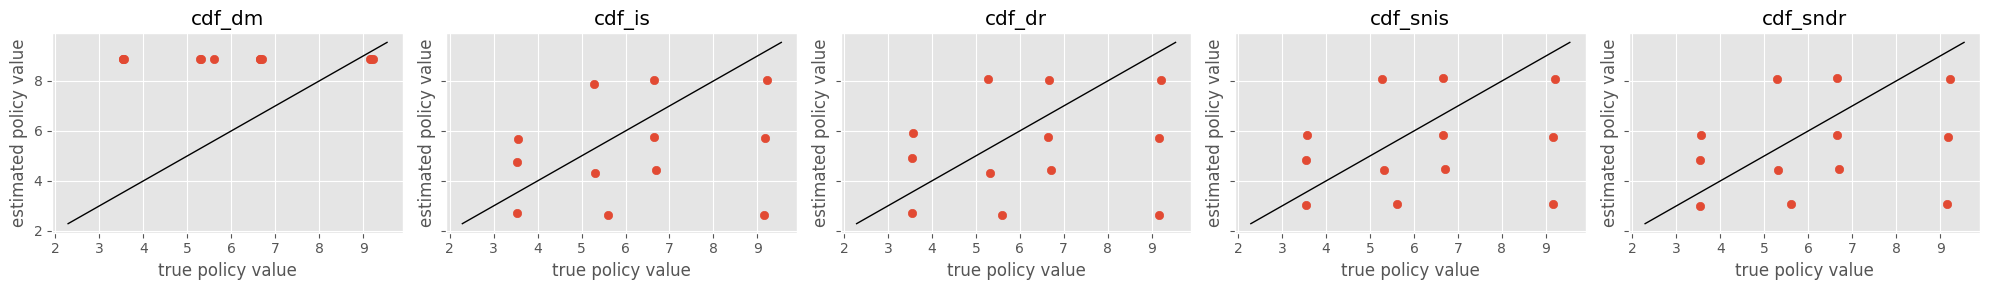

In [65]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

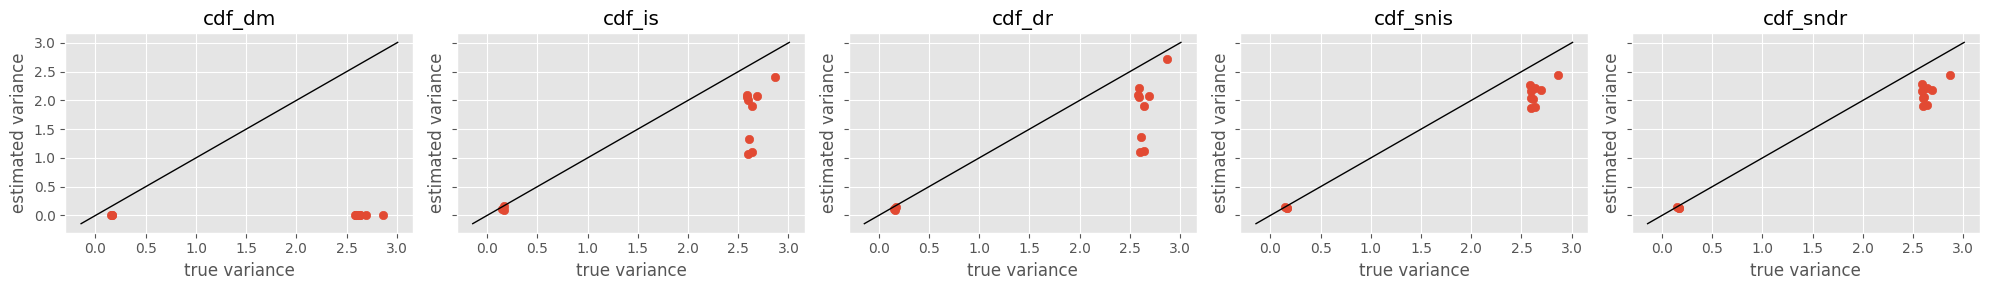

In [66]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

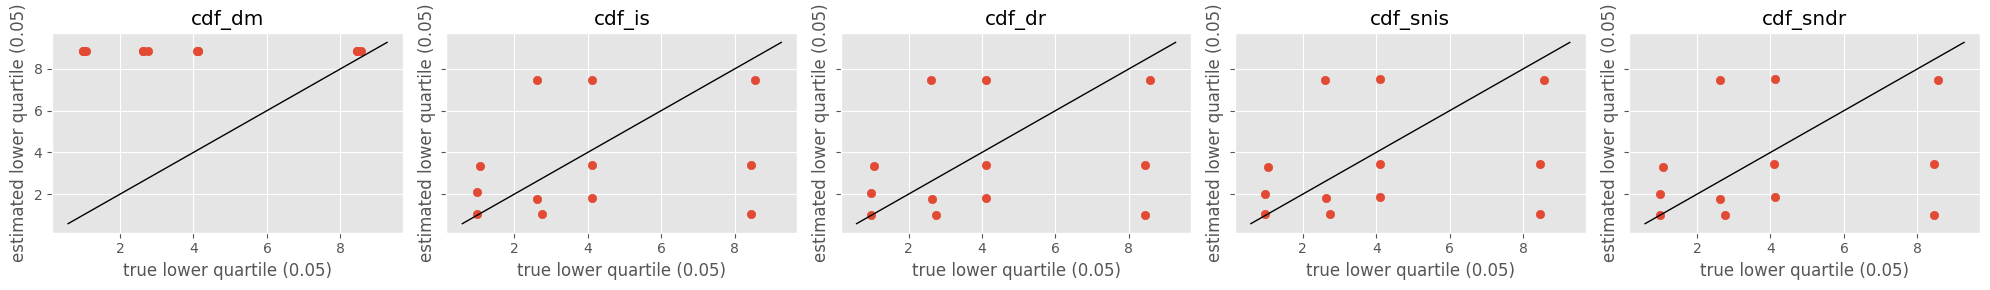

In [67]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

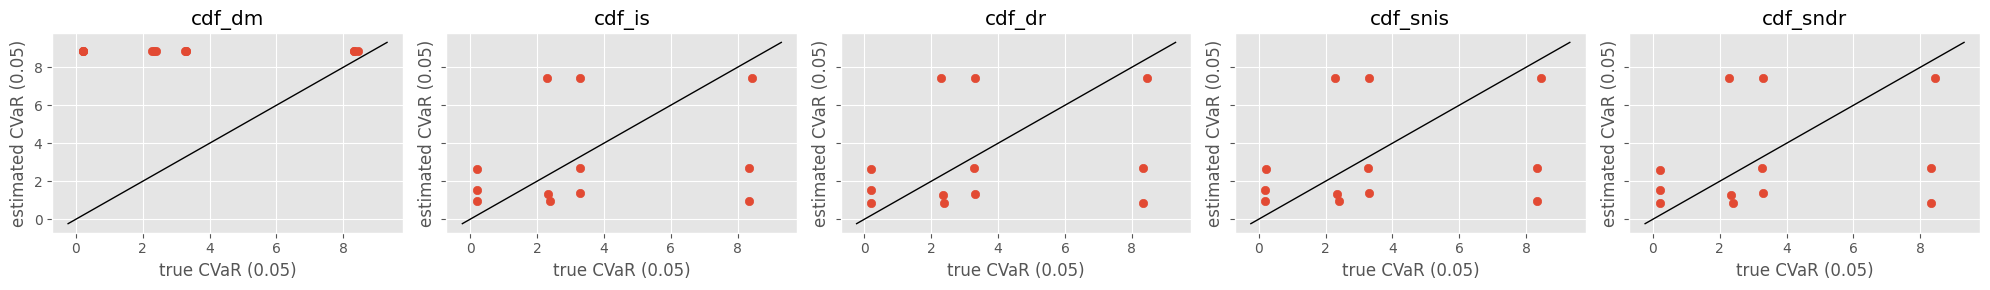

In [68]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

To see how to conduct OPE/OPS with multiple datasets, please refer to [examples/quickstart/basic/basic_synthetic_discrete_multiple_datasets.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_multiple_datasets.ipynb).

For the examples in the continuous action space, please refer to [examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.